# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' # good
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0
# file_path= './data/NCDC/uk/bournemouth/dat.txt' 4?
# file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" 
# file_path= './data/NCDC/uk/marham/dat.txt' 
# file_path= "./data/NCDC/uk/holbeach/dat.txt"
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/cambridge/dat.txt"
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt"
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/barayas/dat.txt" # 
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/南京lukou/dat.txt" 
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/denver/hr_avg.csv'

# file_path = './data/asos/bismarck_ND/hr_avg.csv' # try 4?
# file_path = './data/asos/bismarck_ND/minute_avg.csv' 
# file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012, good fit, try 2
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
file_path = './data/asos/springfield_IL/hr_avg.csv' # good fit

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


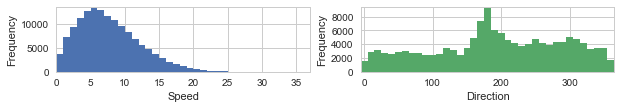

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date      speed_max          speed            dir  \
count  1.419290e+05  141929.000000  141929.000000  141929.000000   
mean   2.008176e+07      13.088129       7.700493     191.780578   
std    4.873256e+04       6.996470       4.487902      94.579688   
min    2.000010e+07       0.000000       0.000000       0.000000   
25%    2.004053e+07       8.000000       4.330000     118.890000   
50%    2.008091e+07      12.000000       7.030000     200.630000   
75%    2.012103e+07      17.000000      10.450000     270.740000   
max    2.016123e+07     137.000000      36.300000     359.990000   

                HrMn          month   dir_windrose  
count  141929.000000  141929.000000  141929.000000  
mean     1149.912280       6.526503     193.402225  
std       692.304836       3.459242      95.843273  
min         0.000000       1.000000       0.000000  
25%       500.000000       4.000000     125.490000  
50%      1200.000000       7.000000     193.020000  
75%      1700.000000      10.000000     273.270000  
max      2300.000000      12.000000     359.990000

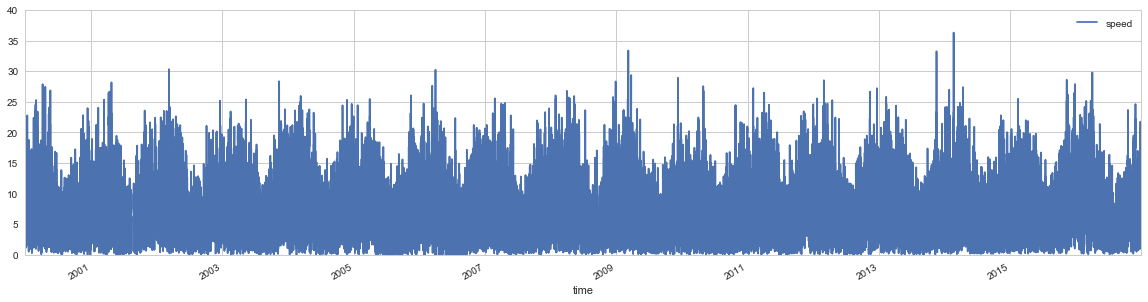

In [7]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

True


### 1.2.2 Sampling Type Selection

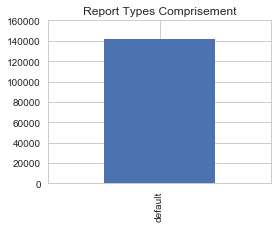

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

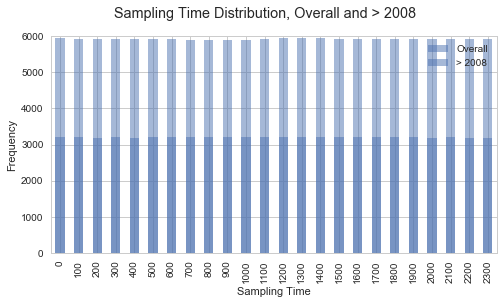

In [10]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5,label='Overall')
df.query('date > @MID_YEAR * 10000')['HrMn'].value_counts().sort_index().plot(
    kind='bar', alpha=0.5, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 4), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

[0]


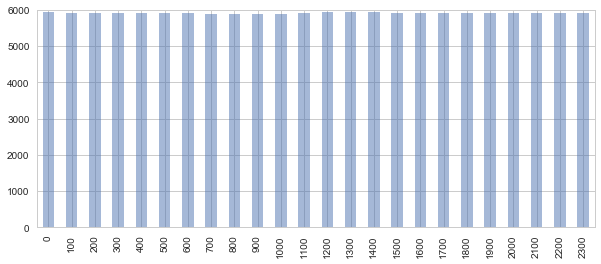

In [11]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)
print(sample_times)

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5, figsize=(10, 4))

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [12]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

date  speed_max  speed     dir  HrMn     type wind_type  \
117725  20140220       56.0  36.30  200.71  1700  default   default   
75178   20090308       48.0  33.38  191.80  1200  default   default   
115566  20131117       52.0  33.24  182.78  1300  default   default   
117726  20140220       48.0  31.27  198.46  1800  default   default   
17275   20020309       45.0  30.32  182.76  1100  default   default   
50367   20060331       42.0  30.23  194.00  1300  default   default   
17274   20020309       44.0  29.90  180.81  1000  default   default   
135684  20160402       47.0  29.79  142.44  1200  default   default   
75179   20090308       45.0  29.78  186.60  1300  default   default   
17277   20020309       41.0  29.56  179.73  1300  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
117725 2014-02-20 17:00:00      2        249.29  11.05           5.03  
75178  2009-03-08 12:00:00      3        258.20   9.56           3.60  
115566 2013-11-17 13:00:00     11        267.22  10.97           6.44  
117726 2014-02-20 18:00:00      2        251.54  -5.03           6.94  
17275  2002-03-09 11:00:00      3        267.24   0.42           1.00  
50367  2006-03-31 13:00:00      3        256.00   3.69           2.68  
17274  2002-03-09 10:00:00      3        269.19   0.59          -0.42  
135684 2016-04-02 12:00:00      4        307.56   0.58           3.58  
75179  2009-03-08 13:00:00      3        263.40  -3.60           2.07  
17277  2002-03-09 13:00:00      3        270.27   0.24           1.58

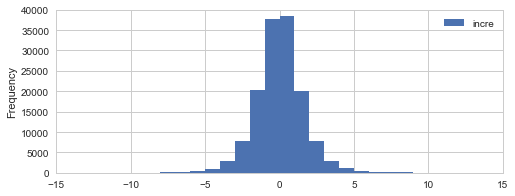

In [13]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [14]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 0


date  speed_max  speed     dir  HrMn     type wind_type  \
117725  20140220       56.0  36.30  200.71  1700  default   default   
75178   20090308       48.0  33.38  191.80  1200  default   default   
115566  20131117       52.0  33.24  182.78  1300  default   default   
117726  20140220       48.0  31.27  198.46  1800  default   default   
17275   20020309       45.0  30.32  182.76  1100  default   default   
50367   20060331       42.0  30.23  194.00  1300  default   default   
17274   20020309       44.0  29.90  180.81  1000  default   default   
135684  20160402       47.0  29.79  142.44  1200  default   default   
75179   20090308       45.0  29.78  186.60  1300  default   default   
17277   20020309       41.0  29.56  179.73  1300  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
117725 2014-02-20 17:00:00      2        249.29  11.05           5.03  
75178  2009-03-08 12:00:00      3        258.20   9.56           3.60  
115566 2013-11-17 13:00:00     11        267.22  10.97           6.44  
117726 2014-02-20 18:00:00      2        251.54  -5.03           6.94  
17275  2002-03-09 11:00:00      3        267.24   0.42           1.00  
50367  2006-03-31 13:00:00      3        256.00   3.69           2.68  
17274  2002-03-09 10:00:00      3        269.19   0.59          -0.42  
135684 2016-04-02 12:00:00      4        307.56   0.58           3.58  
75179  2009-03-08 13:00:00      3        263.40  -3.60           2.07  
17277  2002-03-09 13:00:00      3        270.27   0.24           1.58

### 1.3.2 0 Speed

In [15]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.0287221975637


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [16]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
if integer_data:
    SECTOR_LENGTH = 360/len(effective_column) 
else: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0.00      2
0.01      5
0.02      2
0.03      3
0.04      5
0.05      4
0.06      3
0.07      1
0.08      4
0.09      3
0.10      4
0.11      4
0.12      2
0.13      1
0.14      1
0.15      5
0.16      2
0.17      2
0.18      4
0.19      2
0.20      4
0.21      1
0.22      3
0.23      2
0.24      1
0.25      2
0.26      4
0.27      5
0.28      3
0.29      1
         ..
359.64    1
359.65    3
359.66    5
359.67    4
359.68    2
359.69    2
359.71    6
359.73    4
359.75    1
359.76    1
359.77    2
359.78    1
359.79    1
359.80    3
359.81    2
359.82    3
359.83    2
359.85    2
359.86    5
359.87    1
359.88    2
359.90    1
359.91    1
359.92    4
359.93    4
359.95    3
359.96    2
359.97    1
359.98    1
359.99    2
Name: dir, dtype: int64

1 10


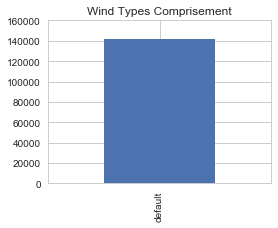

In [17]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

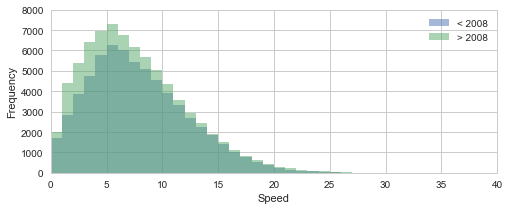

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, df.speed.max() + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

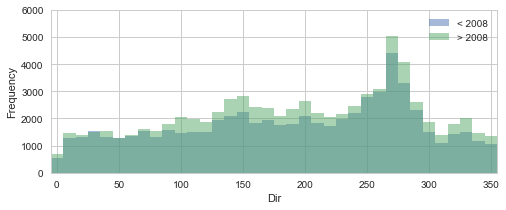

In [19]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), tight='x')

2000 - 2004


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


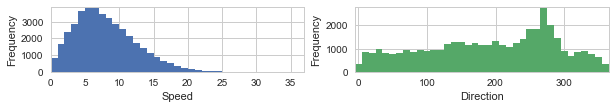

2005 - 2009


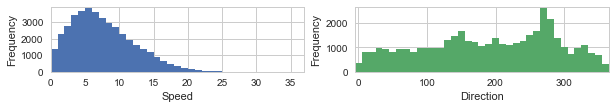

2010 - 2014


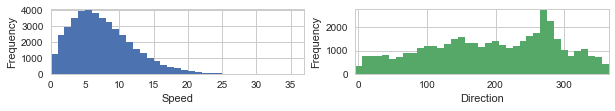

2015 - 2016


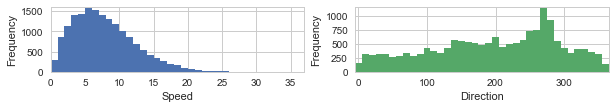

In [20]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [21]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [22]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [23]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [24]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [25]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [0]


date     speed_max         speed           dir          HrMn  \
count  4.287700e+04  42877.000000  42877.000000  42877.000000  42877.000000   
mean   2.012063e+07     13.154815      7.488251    192.502900   1150.362665   
std    1.411208e+04      7.104058      4.458953     93.652051    692.053486   
min    2.010010e+07      0.000000      0.000000      0.000000      0.000000   
25%    2.011040e+07      8.000000      4.130000    119.470000    600.000000   
50%    2.012070e+07     12.000000      6.820000    199.570000   1200.000000   
75%    2.013093e+07     17.000000     10.170000    271.100000   1700.000000   
max    2.014123e+07    137.000000     36.300000    359.990000   2300.000000   

              month  dir_windrose             x             y  
count  42877.000000  42877.000000  42877.000000  42877.000000  
mean       6.533946    197.070298     -1.132658     -1.239373  
std        3.458124     96.171525      5.458072      6.583912  
min        1.000000      0.000000    -33.954378    -27.392133  
25%        4.000000    130.230000     -4.099557     -5.267621  
50%        7.000000    195.790000     -0.726085     -0.796230  
75%       10.000000    278.380000      2.143285      3.215274  
max       12.000000    359.990000     21.423272     22.327037

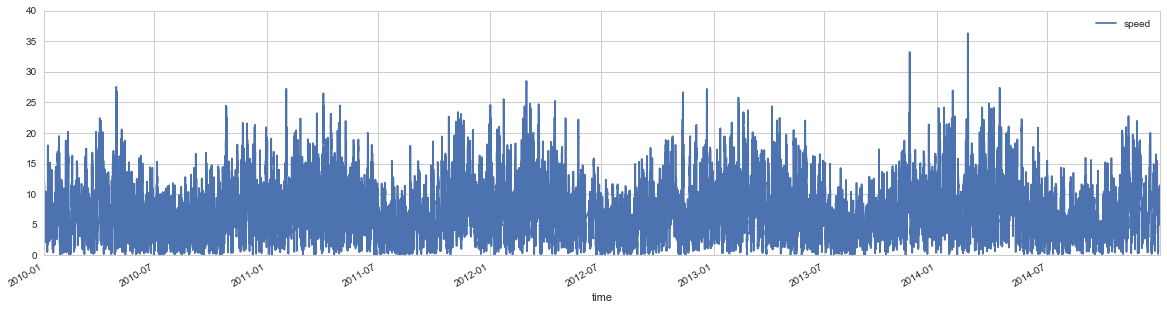

In [26]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

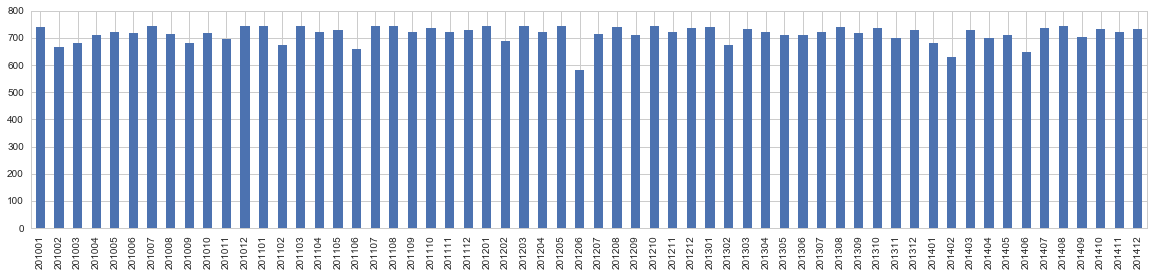

In [27]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


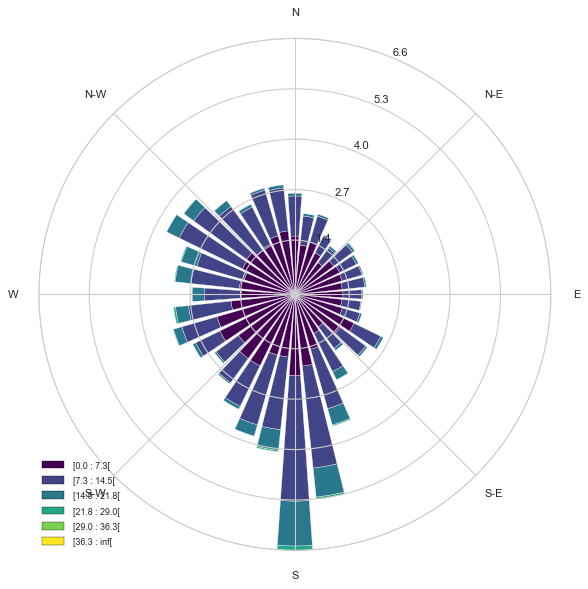

In [28]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [29]:
if len(df) > 1000000:
    bins=arange(0,362)
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min')
    
    df = df_all_years.sample(n=500000, replace=True)    
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min resmapled')
    plt_configure(legend=True, figsize=(20,4))

In [30]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 1. Histogram comparison
fig = plt.figure()
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data', normed=True)             
plot(x, y_weibull, '-', color='black',label='Weibull')   
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF', legend=True)

# 2. CDF comparison
fig = plt.figure()
plot(log(x), log(-log(1-y_ecdf)),'o', label='ECDF')
plot(log(x), log(-log(1-y_cdf_weibull)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'}, figsize=(4,3))
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARsAAADSCAYAAAB6vWTpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzt3XtcVHX+x/HXDCMIzIjghbyBSZGWtgKmpYKFt6zMCyaE
4Za2beXqeumildZ6N+unZWp2MVsMo3Db1HW11JLCVKBI8VaLLq2iICDqDOkwzPz+ICbwgoDMHObM
5/l4+IiZw5nz+Ya++Z7vOd/v0dhsNhtCCOFgWqULEEK4BwkbIYRTSNgIIZxCwkYI4RQSNkIIp5Cw
EUI4hcPCxmq1MmvWLGJjY0lISCA3N/ey7/n111+Ji4sjJyen1vsIIVyTw8Jm27ZtmM1mkpOTmTZt
GgsXLqy2ff/+/YwZM4b//e9/td5HCOG6HBY2mZmZREZGAtC9e3eys7OrbTebzSxfvpxOnTrVeh8h
hOvSOeqDjUYjer3e/trDwwOLxYJOV3HIiIiIOu9zJZmZmQ1YtRCiLq707/hqHBY2er0ek8lkf221
WmsMjfruA3VrsKvJzMxUbfvU3DZwj/bVhcNOo8LDw0lNTQUgKyuL0NBQh+wjhHANDuvZDBw4kLS0
NOLi4rDZbMyfP5+NGzdSWlpKbGxsrfcRQqiDw8JGq9Uye/bsau+FhIRc9n2JiYk17iOEUAe5qU8I
4RQO69moVdLWw5e9Fz+4swKVCOFapGcjhHAKCRshhFNI2AghnELC5jpYLGVYrValyxAq88c//pF9
+/YBFdN6IiIieO+99+zbExISOHTo0GX7paamkpyczPHjxxk9enStj9enTx/751ZOinYEGSCuh5Li
02xKWc32f31Mr8jBPDLkn0qXJBzk2Wef5dNPP63XvmazGU9Pz8vef+ihh1i8ePFV9+vTpw8ZGRnc
fvvtZGZm0rdvX3bu3Mnjjz/OxYsXOXHiBJ07X35RIioqCoDjx4/Xq15Hk7C5iitddaoaMuaLF9Bo
NHyz7XO2bt3K4MGDFahSqFHv3r1ZsWIF48aNY+fOnTz00EO89tprnD9/ngMHDtCzZ0/S09NZsmQJ
Hh4edOjQgdmzZ7Nx40aOHj1KXFwcxcXFPPnkkxQVFXH33XczYcIEpk+fzn333UdUVBSpqals3rzZ
qSsrSNjUQknxaTZ9+j7b/vUxZeaLtGjVhmFxf6bjTbfyypSHmTBhAvv378fb21vpUkUDW7x4cY29
kJrUd27UrbfeytGjR7HZbKSnpzN16lTuuusudu3axZEjR+jbty8zZ84kKSmJFi1asHTpUj777LNq
8whLS0tZvHgxPj4+jBkzhv79+9erDQ1JwqYGZ4oK2JTyPtv/lVwtZKIGjqDJb93je0eMZfP6D1iw
YIHc/SwahFarpXPnzqSmptKqVSs8PT2Jiori66+/5vDhw4wZM4aZM2cyefJkAC5cuEDv3r0JDg62
f0bnzp0xGAwAdOvWjWPHjlU7hhKPi5OwuYKTJ0+SuGrB7yHTug3D454kauBwdE2qn4PHPDKBfXu+
ZOHChcTHx1/xXFqIuurTpw+rVq3i/vvvBypWNlixYgUA/v7+3HDDDaxYsQKDwcD27dvx8fHh5MmT
9v1zcnIwmUx4eXmxb98+YmNj+e677zh9+jQABw8edHqb5GrUJT788EM6derEls/+TrPmAYyf9Df+
7/0tRN83+rKgAWjq7cubb75JWVkZTz/9tCK/MYT69O7dm8zMTPr16weAp6cnBoOBnj17otVqefHF
F3niiSeIi4sjKSnpshUS/Pz8mDJlCnFxcQwePJibbrqJhx56iDVr1vDoo4+Sn5/v9DZpXP3xuw29
ZkinTp0oKCggbvxzV+zJXInNZuP1V57mhz1f89Szi+jb/0GgYaYxqHlNFDW3DaR9l5KeTRVHjx7l
2LFjDB48+Ko9mSvRaDT88amX8PRqykfvvorp/FkHVyqE65GwqWLbtm0ADBgwoM77trqhHSPin+Zc
SRHJa5Y0dGlCuDwJmyoqw6a+lwnvG/lH2gWFsGPzJ/x8KKshSxPC5UnY/MZqtbJ9+3Y6dOjAzTff
XK/P0DXx5LGJL2Oz2Vi97G9YLJYGrlII1yVh85usrCyKi4sZMGAAGo2m3p/Tpdsd9Bs0kl+OHuat
t95qwAqFcG1yn81vrme85lIPj3+GzO+2M3PmTEaNGkX79u2v+zOFcq40daU28vLOcqRQFlurJD2b
31zveE1VBj9/Hh7/DEaj0X6XpxB1sWfPHu666y4SEhJ45JFHiIuLY/PmzVf9/ry8PHbs2OHECutO
ejZU3O79zTff0K1bNwIDAxvkM6MGjeRg+hbWr1/P5s2bue+++xrkc4X7uPPOO1mypOLKpslkIiEh
gRtvvJEuXbpc9r27d+/m6NGjREdHO7vMWpOwAXbt2sWFCxca5BSqklarZeXKlYSHh/OXv/yF7Oxs
fHx8GuzzhXvx9fUlNjaWzZs3s3btWk6dOkVBQQHR0dFMmjSJd955hwsXLhAWFobBYOCtt97CZrNh
Mpl4/fXXufHGG5VugpxGQcOO11TVrVs3pkyZwrFjx5g3b16DfrZwPy1atODgwYN0796d999/n5SU
FD7++GM8PDx44okneOCBB+jfvz8///wzixcvJjExkUGDBrFlyxalSwekZwNUhI1Op7MvPtSQXn75
ZZKTk1m8eDFjx47llltuafBjCPeQl5dHWFgY+/fvZ/fu3ej1esxm82XfFxgYyLx58/Dx8SE/P5/w
8HAFqr2c2/dszpw5Q0ZmJiGd/8CGtOMkbT1c76sPl0raepjPv/0fD475K2VlZUyeLr0bUT9Go5FP
P/0Ug8GAwWDg9ddfZ9y4cVy4cAGbzYZWq7UvUTtz5kzmz5/PwoULad26daOZHOywno3VauWVV17h
yJEjeHp6Mnfu3GrrbezYsYPly5ej0+mIiYlh9OjRlJWVMX36dE6cOIFWq2XOnDlXfIpmQ/r666+x
Wa10DbvLYce4o89AmvkFkPbVpqsuFSkar/peqs7MNBERUf/L3Lt37yYhIQGtVkt5eTkTJ07kxhtv
ZNq0aWRlZeHp6UlwcDAFBQWEhoaycuVKbrvtNh588EHGjBmDt7c3LVu2pKCgoN41NCSHhc22bdsw
m80kJyeTlZXFwoULWblyJQBlZWUsWLCAlJQUvL29efjhh4mOjiYrKwuLxcLHH39MWloaS5cuZdmy
ZY4q0V4nQNew3g47hk7XhD7RQ/n3Zx+yadMmRo4c6bBjCXXo1asX33333RW3bdiw4bL3AgMD2bp1
K4B9DZzGxmFhk5mZSWRkJADdu3cnOzvbvi0nJ4egoCD8/PyAioWB0tPTCQ0Npby8HKvVitForLbM
4bWOVV+bNm3Cq6kP3voW5OXl1ftzrqVLWF/+/dmHLF26tFoPrzaup32NnZrbBupvX104LGyMRiN6
vd7+2sPDA4vFgk6nw2g02pcshIrLekajER8fH06cOMGQIUM4c+YMb7/9dq2OVd81Q3755Rd++eUX
wnvdQ4egoHp9Rm21bduWTjd3JS0tjbZt29KmTZta7afmNVHU3DZwj/bVhcMGiPV6PSaTyf7aarXa
eyqXbjOZTBgMBtasWUPfvn3ZunUrn3/+OdOnT+fixYuOKpHt27cDcJsDx2uqiho0AqvVSmJiolOO
J0Rj4rCwCQ8PJzU1FaiY5Fh12cKQkBByc3MpKSnBbDaTkZFBWFgYzZo1s/d4/Pz8sFgslJeXO6rE
KuM1zgmb3nffj5eXFx988EGjuUIghLM47DRq4MCBpKWlERcXh81mY/78+WzcuJHS0lJiY2OZPn06
48ePx2azERMTQ2BgII8++igvvPAC8fHxlJWVMWXKFIfddWuz2di2bRtt2rShXZBjr3hV8jX4MXz4
cJKTk9mzZw9

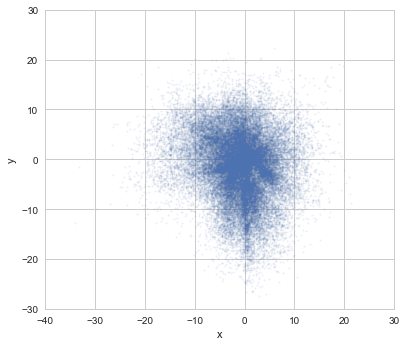

In [31]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [32]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [33]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAM0AAAB6CAYAAAAcc9ekAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAEDJJREFUeJzt3XtMk9cbB/BvC6IEvJAwcXFhExEJ93pDw8A4t6FjDLxO
EV3GxpBsUWZmQAVRqBvKNDFGEC+ow2yKCtui80qmJDJ0IjIEp9QLTgWBDZRypzy/P4j9WSnQI5UW
fD4Jf7ynp30fXvhy3p73lFdCRATGmM6khi6Asb6GQ8OYIA4NY4I4NIwJ4tAwJohDw5igfhWalpYW
xMXFwdPTE56enti0aRNUKpXe+gOAUqmEv78/ampqOu2zdu1ajB07VuMrLi6u0/4lJSVYtGgR3N3d
4efnh+zs7O6/2W589tlnHWrYs2dPp/0vX76MWbNmwc3NDXPmzEFhYaH6sdOnT2PVqlVC+39+30+/
tL3OzZs34eLigosXL2q0Z2RkwNfXFzKZDPPmzcOlS5eEanhpqB9JSEig9957j/Lz8+nChQvk5eVF
27dv11t/IqL4+HjasWNHl30WLFhASUlJVFFRof6qra3V2rehoYF8fHwoJiaGFAoFbd++nVxdXenu
3bvdf8Nd8Pb2pszMTI0a6uvrtfYtLy8nmUxGW7duJYVCQevWrSNPT096/Pixus+cOXPo4sWLOu//
2f1WVFTQ0aNHydnZmQoLCzX6tba20uzZs8nBwYFyc3PV7Tk5OeTq6krHjh2j0tJSSkxMJA8PDyov
Lxc8EvrXb0LT2NhI7u7udPbsWXVbRkYGTZkyhVQqVY/7E7X/Inh4eFBNTU2XtUyaNInOnz+vU92Z
mZk0ZcoUam5uVrcFBwdTQkKCTs/Xpra2lhwcHEihUOjUf9u2bRQYGKjebmtro+nTp1NaWppGncHB
wS9UT11dHXl7e1NycnKHx5KTk2nRokUdQhMfH08hISEaNbm4uNDJkydfqAZ96jenZ9evX0dDQwMm
TZqkbpswYQL+/fdf3Lt3r8f9AeDQoUOQyWQYOnRop3VUVlaipqYGo0aN0qnuK1euQCaTYcCAAeq2
iRMnIj8/X6fna6NQKGBqagpbW1ud+ufn52PixInqbYlEgvHjx2vUMG3aNOTn5+PGjRvC9ezduxcD
BgxASEiIRntJSQn279+P9evXd3iOlZUVCgoKUFRUBCJCRkYGiAgODg7C+9e3fhOaR48ewdzcHIMH
D1a3vfbaawCA8vLyHvcHgHPnzsHb27vLOhQKBSQSCXbt2oWpU6figw8+QGpqKtra2rT2r6iowPDh
wzXarK2t8ejRoy73010NlpaWiIqKwttvv42AgABkZmZ22l+XGoYOHQpXV1ecP39eqJbGxkbs378f
YWFhMDMzU7erVCpERUVh+fLlGDFiRIfnLVmyBK6urpg9ezacnZ0RHR2NjRs36vzH6GXqN6FpaGjA
wIEDNdqe/pCam5t73F+lUqG4uBj29vZd1nH79m1IpVLY2tpi586dCAkJwfbt27F7926hurXVoKtb
t26hsbERU6ZMwe7duxEYGIiYmBgcP368RzXY29vj2rVrQrUcO3YMUqkUAQEBGu27d++GpaUlPv74
Y63Pq6ioQG1tLeLi4nD48GF88sknWLt2LUpKSoT2/zKYGroAfRk0aFCHH/LTbXNz8x73r6mpgUql
gpWVlbrt888/R15ennr7+PHjCAoKgp+fH4YNGwagfRbp8ePH2LdvH7744gud6xg0aJDW79PPzw8P
Hz5Ub2s7jfvmm2+wdOlS9Wmko6Mj/vnnH6SlpcHPz++Faxg2bBhu376tta7O/Pbbb5g5c6ZGKBUK
BVJTU3HkyBFIJBKtz4uNjYWXl5c6VM7OziguLsaePXuQkJAgVIO+9ZvQjBgxAvX19VAqlbC0tATQ
/v4CAGxsbHrc/+kP99nTrA0bNqCxsVG9PXz4cEgkEnVgnrK3t0dVVRVUKhVMTEw0HrOxsVHv96nK
ykqtNQDAzp070draqvWxp0xMTDq87xo9ejTOnTuntb+uNahUKkilup+c1NfX49KlSwgNDdVoP3ny
JGpra/HRRx9ptIeGhiIwMBBxcXEoLCxEcHCwxuMuLi4oKCjQef8vS78JjaOjI8zNzZGXl4epU6cC
aL/2YG1trfUNsWh/KysrmJqaorq6Wt2m7Rd7w4YNUCgU2Lt3r7rt2rVreOuttzoEBgBkMhk2b96M
1tZWmJqaquuQyWRav8+RI0d2dRgAAF999RWGDh2KDRs2qNuKiopgZ2entb9MJtMIFBHhypUrHd64
V1dXq9/36aK4uBhEhHHjxmm0BwcHw9/fX73d0NCAgIAAyOVyeHl5AWg/tgqFQuN5CoVC58mNl8qw
k3f6FR8fT++88w5dvnyZcnJyyMvLS+OaSnV1NVVXV+vc/3lz586llJSULmvIzc0lR0dHSklJodLS
UsrMzCQPDw/65ZdfiKj9ukRFRQU1NDQQEZFSqSQvLy+KiooihUJBSUlJ5ObmRvfu3Xvh45CZmUlO
Tk505MgRKi0tpX379pGzszP9+eefRETU1NREFRUV1NTUREREZWVl5O7uTps3byaFQkHr16+nyZMn
05MnTzRed9asWZSamkpE7deXKioqqLW1tdM6Dhw4QO+//3639SqVyg5Tzvv27SMPDw/1dZqUlBRy
cnKi69evCx8PfZMQGe5DaM++H9CH5uZm7N+/H7m5uRgwYAB8fHywYMEC9SlFfHw8ACAmJkan/s/L
yMhASUkJIiMju6zj0qVLyMjIQFlZGaysrODv74/p06cDaD/tWb58OcLCwtQj3N27d5GamorS0lLY
2NggODgYbm5uPToWZ8+exYkTJ1BVVQUbGxvMmzdPPa1cXFwMuVyO6OhoODk5AWgfDX/44Qc8evQI
tra2+PTTTzVGpvr6eoSFhWHTpk14/fXXcf78eaSkpGDr1q2djj6HDx9GYWFhl6shgPYZtpCQEI16
iAinTp3CmTNn8N9//2HkyJFYuHAhnJ2de3RcRIwfP177A4ZM7OXLlw25e2Hl5eXk7u5OWVlZhi7l
hfTkeB88eJCWLFmi0RYaGkqVlZU9Latbhvg96Wqf/WbKuTfY2Nhg1qxZyMrKMnQpvYqI8NNPPyE8
PFzdduXKFUilUlhbWxuwMsPg0AhasWIF/vjjjy4XbPY3J0+ehIODAyZPnqxuc3NzQ3JysgGrMpx+
M3vWWwYPHozExMQO08r92cyZMzFz5kyNtqczfa8iHmkYE8ShYUxQl2NsS0sLVq9ejQcPHqC5uRnh
4eGwt7dHVFQUJBIJxowZg9jYWEilUqSnp+PgwYMwNTVFeHg4pk2b1lvfA2O9qsvQ/Prrrxg2bBgS
ExNRU1ODwMBAODo6IiIiAp6enli7di2ysrLg4eGBtLQ0HD16FE1NTQgKCoKXl5fGqlbG+osuQzNj
xgz4+voCaJ92NDExQVFRkfozKD4+Prhw4QKkUilkMhnMzMxgZmYGW1tb/P333z2+QMeYMeoyNBYW
FgDaPxe/bNkyREREYOPGjerFixYWFqitrYVSqdT4XIqFhQWUSqVOBeh7VUBv4bp7lzHV3e28YVlZ
Gb788ksEBQXB398fiYmJ6sfq6uowZMgQWFpaoq6uTqP92RB1pdOlCkYsLy+P6+5Fhqi7q5B2OXtW
VVWFkJAQrFy5EnPnzgUAODk5qf9rSHZ2NiZMmAA3Nzfk5eWhqakJtbW1uHXrllF8LJWxl6HLkWbH
jh148uQJkpKSkJSUBABYs2YN5HI5tmzZAjs7O/j6+sLExASLFy9GUFAQiAhff/11h08CMtZfGHyV
M58u9B6uWz/75IubjAni0DAmiEPDmCAODWOCODSMCeLQMCaIQ8OYIA4NY4I4NIwJ4tAwJohDw5gg
Dg1jgjg0jAn

## 2.3 Overview by Month

In [34]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXd4XNW19n/TZ6QZzWhGvRdbzZIrGFxxAduAwZQAuUko
N9zkIyThS/KlQCgOhCRwIZAEEm4SargOxQRCTDPGYGyDu42LbPWukWZGo+m9nO8PobGFJFu2R8VE
7/PoeaRz9uyz5+i8Z6299lrvFgmCIDCJSUzinIB4vAcwiUlMYuSYJOwkJnEOYZKwk5jEOYRJwk5i
EucQJgk7iUmcQ5gk7CQmcQ5hkrD/BphcufvyYJKwY4Bly5ZRWlrKQw89NOT5zs5OSktLKS0tpbe3
N67X/uCDD1i7dm3s7yeeeIJZs2bF9Rput5ulS5fy3nvvxbXfSQzGJGHHCCKRiE2bNg15buPGjaN2
3RdeeAGTyTRq/bvdbm6//XaMRuOoXWMSxzFJ2DHCrFmz6Ojo4OjRo4POvffee5SWlo7DqM4Ou3fv
5rrrrqOmpma8h/Jvg0nCjhHKy8vJzc0dZE2NRiOHDx9m1apVgz6zadMmrr32WmbOnMlFF13E7373
O8LhcOz8smXL+Otf/8ratWuZO3cus2fP5mc/+xlutxuAG2+8kd27d7NlyxZKS0vp6OiIffadd95h
5cqVVFVVcc0117B///7YuY6ODkpLS3niiSdO+p2++93vUlJSwtNPP31G92QSp49Jwo4hVqxYMcgt
3rhxIzNmzCAjI2PA8VdeeYXvfe97TJ8+nSeffJJvfOMbPPvss9x5550D2v35z3/G6XTy2GOP8YMf
/IC3336bp556CoC1a9dSUVHB7NmzeeWVV0hLSwPA5/Px+OOPc8cdd/D73/8en8/H97///djLIC0t
jVdeeYXrrrvupN9n3bp1/P73v0ev15/VfZnEyCEd7wH8O2HVqlU888wzNDY2UlxcDPS5w5deeumA
dpFIhN/97ndcfvnlsYDRwoUL0Wg0rF27lv/6r/+irKwMgIyMDB577DFEIhELFy7k448/5umnn2bu
3LlcdNFFqNVqEhIS+NGPfsTf/vY3oC9q/MgjjzBz5kwAwuEw3//+92loaKCsrAy5XB47dzKUlJTE
7d5MYmSYtLBjiKqqKjIzM3n//fcB6Orq4tChQ6xcuXJAu6amJnp7ewe5yZdffjkAe/fuHdCnSCSK
/Z2amgr0WVeXyzXkOCQSCdOnT4/9nZ2dDTBs+0lMHEwSdgwhEokGuMUbN25k+vTpZGZmDmjncDgA
MBgMA45rNBrkcnlsjgqgUqkGXUMikbBw4UJ+85vfDDkOhUKBWHz8X9//ezQaPcNvNomxwiRhxxgr
Vqygurqajo4ONm7cOMgdBtDpdABYrdYBx51OJ8FgMHb+ZLjzzjvZsWMHdrs9PgOfxITAJGHHGLNn
zyY1NZWXX36ZgwcPDnKHAQoLC0lOTh6UiPDOO+/E+jgV1Go1v/zlL2lpaRkQWZ7EuY3JoNMYQywW
c8kll/D888/H5rRfhEQi4Xvf+x6//OUv0Wq1LF++nNraWp544glWrVo14mDPwoULSU1N5cCBA6hU
KgKBwIg+FwwGOXr0KBkZGYOi15MYX0xa2HHAihUrCIVCQ6699uMb3/gGv/rVr9i1axe33XYb69at
4z//8z959NFHT+taDzzwAD6fj56eHhoaGkb0GbPZzA033MD69etP61qTGH2IJjWdvlzo6Ojgpptu
4sMPP4wd2759O7feeiubN28mJydnHEc3ibPFJGEnMYlzCJMu8SQmcQ5hkrCTmMQ5hEnCTmIS5xAm
l3W+BIhGo0QikZiyhCAIsd9FItGAH4lEMiCVcTzw4Ycf8uSTT+L1elm4cCH33HPPgPNms5l77rkH
k8mESqXi0UcfnQyWfY7JoNMEhiAIhEIhgsEgoVAo9hMIBGLHwuHwaacUSiQSZDIZMpkMuVyOXC6P
/S2TyVAoFEilo/Mub29v52tf+xrr16/HYDBw88038+1vf5slS5bE2txyyy2sXLmS//iP/+Cll15i
x44d/OEPfxiV8ZxrmCTsBIEgCASDQbxeLx6PB4/Hg9frJRqNIhaLYz9SqRSpVBojmkKhiP3eTzKx
WEwkEuGzzz5j5syZiEQiBEEgHA4TDAYJBAKDSN9P/Gg0iiAIyGQyEhISYtU+CQkJcSHxs88+i8lk
4q677gLAZDIhl8tJTk4GoLe3l8suu4wdO3YgEokIBoMYjUYKCgrO+tpfBky6xOOEcDiMy+UaRE6p
VIpMJkOlUmEwGNBqtchksrO6Vn9yv0QiQaFQoNFohm0rCAI+nw+Hw4HH46Gnp4dQKEQ0Gh1A4sTE
RNRq9Wm7162trcjlcm699VbMZjPLli3jBz/4Qex8e3s7WVlZPPTQQ+zYsYPMzEzuu+++M/viX0JM
EnYMEQgEsNvt2Gw2PB5PzDVNSEggNTUVrVaLRCIZ1zGKRKKYRT0RwWAQm82G0+nEYrFgNBoRiURo
tVp0Ot2Ixx6JRNi2bRvr1q0jMTGR22+/nTfeeINrrrkG6HuRVVdXc/vtt3PXXXexfv167rzzTl58
8cVR+b7nGiYJO4oQBAGv14vNZsNutxMIBJDJZKjVarKzs09q6SYa5HI56enppKenA32Brt7eXqxW
K21tbUQiERITE9Hr9Wi1WhQKxZD9pKSkMG/evFjp4PLlyzl06FCMsKmpqSQkJHDxxRcDsHr1ah58
8MEx+IbnBiYJG2cIghBzJe12O9FoFIVCgU6nIz09/azd24kCsVhMSkoKKSkpAHg8HsxmM93d3bS3
t6NQKEhOTiY1NRW5XB773NKlS/npT3+Kw+FArVazfft2li1bFjufl5dHZmYmH374IcuWLePjjz+m
oqJizL/fRMVk0ClOiEQi2Gw2TCYTgUAAhUKBwWAgLS1tQLH4WI6nP+g01m52IBDAZDJht9sJhUJo
tVrS0tLQaDSIRCJee+01nn/+eUKhEPPmzePee+/lvvvuY9myZSxfvpympibWrl2LzWYjMTGRhx56
iMLCwjH9DhMVk4Q9S/j9fsxmMz09PYjFYnQ6HdnZ2eNuSceTsCfC7XbT2dmJx+NBKpWSnp6OwWAY
tWWjLzsm79oZQBAE7HY7JpMJj8eDUqkkPz8fvV4/7kkJEw1qtZrS0lIikQhdXV10d3fT2dmJXq8n
LS1tUHBrEifHpIU9DQiCQG9vL52dnUQiEdRqNbm5uSiVyvEe2iBMFAs7FGw2G0ajEb/fj1qtJicn
h8TExPEe1jmBSQs7AgiCgNPppL29nVAoRHJyMrm5uROOCOcKkpOTSU5Oxufz0draSk1NTWwqMRFf
fhMJk4Q9BdxuN+3t7fh8PnQ6Hfn5+ZNEjRNUKhVlZWX4fD6am5uprq7GYDCQlZU1ILI8ieOYJOww
8Pl8dHR04HK50Gg0VFVVjXsg6csKlUpFRUUFbreblpYWjhw5QlpaGhkZGZPBqS9g8m58AeFwmPb2
dnp7e0lISKC8vHyQ9u8kRgdqtZrKykp6e3vp6OjAYrGQmZlJenr6ZDDvc0wS9gTYbDZaW1sRi8VM
nTqVpKSk8R7SvyX0ej16vR6j0UhXVxe9vb0UFRVNzm+ZJCzQZ1VbW1txOBykpqaSnZ09LskOkxiI
rKws0tLSaGho4OjRo2RlZf3bW9t/e8LabDZaWlqQyWST7m8c8aMf/Yjq6uqYVfze977HJZdcEju/
Y8cOHn74YSKRCNnZ2Tz88MNotdpB/UilUsrKyujp6YlNVf6dre2/7TrsiVY1PT2drKysL9Wbe7zX
YVesWMGrr7465LYikUiEpUuX8txzz1FcXMyjjz6KWCzmRz/60Un7jEQiNDQ04PF4/m2t7YTx+/o3
Ef74448HHF+

## 2.4 Create input data, i.e. speed_set

In [35]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [36]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16]


In [37]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [38]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [39]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


1.1
Wall time: 2min 23s


In [40]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 1.1 1089
[  4.68195902e-07   1.14195944e-06   3.90634715e-06   9.29172435e-06
   1.35021599e-05]


In [41]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvWuUM2d1LviUpJLUUkvd6vv9+mEwJnb4COFATMjxxCsc
L3IIJjevk8mE+BCSySEZIAn3BQfbhJBA5gwwHkICnAlkGcKsJItAQhIwMGFIYuPxZGHsJN/X925d
WlLrfq3L/FDvt1+VqkpVUnW31K5nLS/31116VZKqHu1372c/W1BVVYULFy5cXFF4LvsEXLhw4eI8
4ZKcCxcurjRcknPhwsWVhktyLly4uNJwSc6FCxdXGi7JuXDh4krDJTkXLlxcabgk58KFiysNl+Rc
uHBxpeGSnAsXLq40XJJz4cLFlYZLci5cuLjScEnOhQsXVxouyblw4eJKwyU5Fy5cXGm4JOfChYsr
DZfkXLhwcaXhkpwLFy6uNFySc+HCxZWGS3IuXLi40nBJzoULF1caLsm5cOHiSsMlORcuXFxpuCTn
woWLKw2X5Fy4cHGl4bvsE3Bx+VBVFY1GA5Ikwev1QhRFeDweCIJw2afmwkXfEFRVVS/7JFxcHur1
OvL5PCKRCJrNJgDg6OgIsVgMkUgEHo/HJT0XQw03knsWQ5ZlVKtVHB8fIxwOQ5IkiKIIVVWhqipk
WYYkSWg0GhAEAV6v1yU9F0MHl+SehVBVFZIkQZZlCIIAWZZx8+ZNyLIMn88HRVFQqVQQCATg851d
IkR69XodHo8HXq8XXq8XPp/PJT0XAwt3u/osg6IoaDaboI89Ho8jm81iZWUFfr8fjUYDiUQCgiCg
2WzC5/MhFAphZGQEoVAIXq+3bT1aRxAERnY+n6/jOBcuLgtuJPcsAW0/ZVkGAEiShIODAyiKAlEU
EYlE0Gg0EAwGIYoixsbGEA6HUa/XUalUkM/nkUwmGekR8fFkJkkSVFVFvV5HKpXC7Ows/H6/S3ou
LhUuyT0LoCgKJEmCoigQBAHFYhGHh4eYmJhANBrF3t5e2/GCIEBVVQiCgGAwiGAwiImJCaiqilqt
hmq1ilwuh0QiAVEUGeHxpFcul9FoNBjp0fbWjfRcXDRckrvioDwaFRMSiQQKhQKWl5dZpGY1YyEI
AiMznvQqlQpyuRzi8Tj8fj9CoRBUVWWkCpzlAV3Sc3HRcEnuikJRFMiyDEVRAACNRgP7+/vw+/3Y
3NxkBYV+igU86dFzUqSnKAr29/cRCARYPm9kZAQeT0t/7pKei4uCS3JXEIqiIJ1OI5/PY2VlBScn
J0gkEpiZmcHExEQHsWkjOdqu2oXH42H5ukKhgPn5eVapzWazqNVqCAQCbdtbM9IrlUqIRqMIBAIu
6bnoGS7JXTHQ9hRoEcfBwQGq1SrW19cRDAY7jj9P2YfH40EwGEQoFALQIt9qtYpqtYpMJoN6vY5g
MMgivWAw2EZ6qVQKPp8PkiS5kZ6LnuGS3BWBVvvWbDZRKpUwPj6Ozc1NRh5GjwXOl/CAFumFw2GE
w2EAZ6RXqVSQTqcZ6VGkR8UPiiyNtrd+v9/V6LkwhEtyVwBa7Vs6nUYqlYLf78fi4qLpY/XIodft
ql1oSY86MKgLQ5IkJBIJhMNhFul1K2RQ761Lei4ILskNOSh6A1okcXh4CEmSMDc3h0KhYGmNQdGD
e71ejI6OYnR0FACwtbWFaDSKRqOBVCqFZrPZFunpkV6z2UStVmOkJwgCRFF0t7fPYrgkN6TQbk9L
pRIODg4wPj6OlZUVlMtlS+RlFPE4QXz9riEIAkKhEMbHxwGcRXqVSgXJZBKSJDHSC4VCCAQCHaQX
j8fZGm6k9+yES3JDCF77BgDJZBInJydYXFxEJBJhx/VKMk4QwHmQiDbSkySJkV4ikYAkSW1ylUAg
wM7FKNJzSe/qwyW5IYKqqshkMhBFEcFgEM1mEwcHBxAEAZubmxBFkR1r9aa9qPzbecDn8yESiTBi
50kvl8tBlmVWcAkEAm0FCp70KKdHxOeS3tWCS3JDAmrNOjk5YXmqw8NDTE1NYWpqquOm7Je8hpH4
9Ejv6OiI/V+W5TazAZ70FEVhBRye9Hw+H3w+n0t6QwyX5IYAsiwzQ0sAODk5QaPRwOrqKtOg9Qq+
T5X/3VUAERQRX7PZbIv0FEVhhBcKhdoiOJ70ms0misUiZmdnXdIbQrgkN8DQFhdqtRpKpRICgQCu
XbtmWjEc5m3oeUEURYiiiGg0CgBoNpuoVCqoVqvIZrNQVbUt0iPSkyQJlUqFbW8FQXAjvSGCS3ID
Ct45BACy2SySySSCwSDGxsa6SiKskhzdnIVCAfl8nolwnw0ESZZSY2NjUFW1LdLLZrMAgJGREWYk
yke8fKTnkt5gwyW5AQSvfVMUBUdHR6jValhfX2c3n1MgEo3H4xgbG0OpVEK5XIbH40Gz2WRbucvQ
mTklY7FCOIIgwO/3w+/3t5FepVJBsVhEvV7H9va2bqQHuKQ3yHBJboCg3Z5WKhXs7+8jEomw1iw7
EVq348iZBAA2NjbY8alUCkAr0ikUCkgmkxBFsU2eYYX0nCCpyyIHnvREUUQ2m8Xs7CwqlQrK5TLS
6TQ8Hk/be2JEekBL/kJiZl7P5+L84ZLcgECrfTs+PkY6ncbCwgLGxsZ6WtOMZAqFAg4PDzE9PY1q
tQqv18sa+4lMY7EYYrFYm2/cyckJ4vE4cxPRNtYTrtJNrKoq65H1+/0YHx9nYxwrlQpKpRJSqRS8
Xm9bIYOP4BRFQSqVQjgcRiQSaRsKRJ0ZLs4HLsldMlRVRblcRjwex8rKCmRZZrbkm5ub8Pv9bcfb
zbVpoSgKkskkCoUCq86mUinTNXnfuMnJSeYbp9dYT6Q3KLC6XbULQRAQCAQQCATYFwGRXrFYZKTH
W8XzhgN6kR4NBXJJz1m4JHeJoOICTcAiW/JYLIaZmZm+muf1jqPtqc/n61qdNQPvG0evg6qU1GMK
gPXODvv2zApR6pFevV5HtVplW35ySwbOChra7W2j0QCAjqFAw/z+XTZckrsk8NtTskY6PDzE0tIS
a1vSgx1pCH9cPp/H0dERpqenMTk52aGLo/Pg/28VHo+nrd1KlmXs7u4yFxFJkgxFuMOAXnKL/HwM
Ir29vT34fL6OoUD8JDR6X2jokHbmrUt69uGS3AVDz/ft4OAAqqri2rVrbXNOzdboBj5CSCQSKBaL
joiHrYC2XhMTEwgGg0xnRjk90qPxItzzglPb1X7XoIprNBplMzDIKj6fzyORSMDv93cUd/RILx6P
Y35+vm0Smkt6xnBJ7gKhnZpF0dXExASbcdoNdnpSFUXB1tYW/H5/1+3peerifD4fotFohwiXcnrk
NsIn7AcJ55HXszMUiJ+EJggCqtUq64JxI73uGKyr6QqD176pqoqjoyOUy2Wsra0xiYIVWN1KFgoF
qKqKWCymO9dBu6b235Q76gdG56kV4WqrlD6fDyMjI2wYz3lGehcJM7I0GwrEV7TpfdG6ObvbW2O4
JHfO0GvN2t/fx8jICDY3N+H1eiHLsq2xgGbH8ttTAJicnLR8npdxIxgl7CuVClRVZRPG+CqlmZW7
FhcpKHZyHb64o61oq6qKnZ0d3aFAPOlJkuSSHlySO1doG+szmQxSqRTm5uYQi8XY7+0k+s2Ordfr
bWMHn3nmGctrOo1e1+QT9icnJ1heXoYsy7oTv4w0ek6di9Pohyx50stms9jY2GBfBt2GAgH6pFev
1zE6OnrlOzJckjsHqKoKWZbx1FNP4dq1awCAo6MjNBoNbGxsMDNHgt1qpt6xlN+jsYO9nDNd6IPU
3K+n0aM5EKTRo79r50A4hcuKcvVAn4uejEdvKJAZ6e3s7GB1dZUJkkmczEeEVwEuyTkMbWN9uVxG
IpFANBrF0tJ

In [42]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [43]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [44]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.463   0.500   0.108  4.808  4.380  -0.094
2  0.298  -0.309  -7.283  3.549  5.890  -0.210
3  0.238  -5.336   3.709  6.371  5.233   0.224

GMM Plot Result
0.463150104994 [[ 0.50020012  0.10831675]] [ 4.28556244  4.89194893] -112.545277654
0.298456970778 [[-0.30892078 -7.28295223]] [ 3.42880999  5.96065597] -169.173286658
0.238392924228 [[-5.33625642  3.70861585]] [ 4.90103086  6.63001489] -65.7286468773


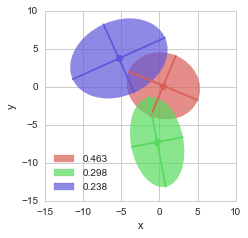

In [45]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [46]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQNOddJvhkZdZ99FV9392fhAkJg2REDMuYQ/gLg8Jg
jDisCWLHQsMxxNoQtsFCtgcPtmyZQ44Z7NBgE8ITMl7L61jwOkzM4mtxYDDIaLWMLuOvu7/urq6r
6+i6K+/9o/p9OysrMyuzKuvrqlY+EQr115355ltVmU/97odRVVWFBw8ePFxR+C57Ax48ePAwSngk
58GDhysNj+Q8ePBwpeGRnAcPHq40PJLz4MHDlYZHch48eLjS8EjOgwcPVxoeyXnw4OFKwyM5Dx48
XGl4JOfBg4crDY/kPHjwcKXhkZwHDx6uNDyS8+DBw5WGR3IePHi40vBIzoMHD1caHsl58ODhSsMj
OQ8ePFxpeCTnwYOHKw2P5Dx48HCl4ZGcBw8erjQ8kvPgwcOVhkdyHjx4uNLwSM6DBw9XGh7JefDg
4UrDIzkPHjxcaXCXvQEPlw9VVSEIAiRJAsuy8Pv98Pl8YBjmsrfmwcPQYFRVVS97Ex4uDzzPo1Kp
IB6PQxRFAEA6ncbMzAzi8Th8Pp9Heh4mGp4l9wqGLMtotVo4PT1FNBqFJEnw+/1QVRWqqkKWZUiS
BEEQwDAMWJb1SM/DxMEjuVcgVFWFJEmQZRkMw0CWZezt7UGWZXAcB0VR0Gw2EQwGwXEXtwghPZ7n
4fP5wLIsWJYFx3Ee6XkYW3ju6isMiqJAFEWQjz2TyaBUKmFjYwOBQACCICCbzYJhGIiiCI7jEIlE
EA6HEYlEwLJs13pkHYZhKNlxHNdznAcPlwXPknuFgLifsiwDACRJQiqVgqIo8Pv9iMfjEAQBoVAI
fr8fU1NTiEaj4HkezWYTlUoFuVyOkh4hPi2ZSZIEVVXB8zzy+TwWFxcRCAQ80vNwqfBI7hUARVEg
SRIURQHDMKjVajg5OcHs7CwSiQSOjo66jmcYBqqqgmEYhEIhhEIhzM7OQlVVtNtttFotnJ2dIZvN
wu/3U8LTkl6j0YAgCJT0iHvrWXoebjU8krviIHE0kkzIZrOoVqtYX1+nlprdiAXDMJTMtKTXbDZx
dnaGTCaDQCCASCQCVVUpqQIXcUCP9Dzcangkd0WhKApkWYaiKAAAQRBwfHyMQCCA3d1dmlAYJlmg
JT1yTWLpKYqC4+NjBINBGs8Lh8Pw+Tr15x7pebhV8EjuCkJRFBQKBVQqFWxsbKBcLiObzWJhYQGz
s7M9xKa35Ii76hQ+n4/G66rVKpaXl2mmtlQqod1uIxgMdrm3VqRXr9eRSCQQDAY90vMwMDySu2Ig
7inQIY5UKoVWq4Xt7W2EQqGe40dZ9uHz+RAKhRCJRAB0yLfVaqHVaqFYLILneYRCIWrphUKhLtLL
5/PgOA6SJHmWnoeB4ZHcFYG+9k0URdTrdUxPT2N3d5eSh9m5wGgJD+iQXjQaRTQaBXBBes1mE4VC
gZIesfRI8oNYlmbubSAQ8Gr0PJjCI7krAH3tW6FQQD6fRyAQwOrqquW5RuQwqLvqFHrSIx0YpAtD
kiRks1lEo1Fq6fVLZJDeW4/0PBB4JDfhINYb0CGJk5MTSJKEpaUlVKtVW2uMSz04y7KIxWKIxWIA
gP39fSQSCQiCgHw+D1EUuyw9I9ITRRHtdpuSHsMw8Pv9nnv7CoZHchMKvXtar9eRSqUwPT2NjY0N
NBoNW+RlZvG4QXzDrsEwDCKRCKanpwFcWHrNZhO5XA6SJFHSi0QiCAaDPaSXyWToGp6l98qER3IT
CG3tGwDkcjmUy2Wsrq4iHo/T4wYlGTcIYBQkorf0JEmipJfNZiFJUle5SjAYpHsxs/Q80rv68Ehu
gqCqKorFIvx+P0KhEERRRCqVAsMw2N3dhd/vp8fafWhvVfxtFOA4DvF4nBK7lvTOzs4gyzJNuASD
wa4EhZb0SEyPEJ9HelcLHslNCEhrVrlcpnGqk5MTJJNJJJPJnodyWPKaROIzIr10Ok3/L8ty17AB
LekpikITOFrS4zgOHMd5pDfB8EhuAiDLMh1oCQDlchmCIGBzc5PWoA0KbZ+q9ndXAYSgCPGJothl
6SmKQgkvEol0WXBa0hNFEbVaDYuLix7pTSA8khtj6JML7XYb9XodwWAQ165ds8wYTrIbOir4/X74
/X4kEgkAgCiKaDabaLVaKJVKUFW1y9IjpCdJEprNJnVvGYbxLL0JgkdyYwrt5BAAKJVKyOVyCIVC
mJqa6lsSYZfktDEqp+dOOshIqampKaiq2mXplUolAEA4HKaDRLUWr9bS80hvvOGR3BhCW/umKArS
6TTa7Ta2t7fpw/dKgFtlLHYIh2EYBAIBBAKBLtJrNpuo1WrgeR4HBweGlh7gkd44wyO5MYLePW02
mzg+PkY8HqetWU4sNCcjlEZhubmx5mWRg5b0/H4/SqUSFhcX0Ww20Wg0UCgU4PP5ukpWzEgP6JS/
kGJmbT2fh9HDI7kxgb727fT0FIVCASsrK5iamhpozWHq5Nwo5L0qUFWV9sgGAgFMT09TGcdms4l6
vY58Pg+WZbsSGVoLTlEU5PN5RKNRxOPxLlEg0pnhYTTwSO6SoaoqGo0GMpkMNjY2IMsyHUu+u7uL
QCDQdbzTWJsdXOUYnF131SkYhkEwGEQwGMTMzEwX6dVqNUp62lHx2oEDRpYeEQXySM9deCR3iSDJ
BaKARcaSz8zMYGFhYajm+atMXLcadojSiPR4nker1UK1WkUul6PTkoGLhIbevRUEAQB6RIE80hsc
HsldErTuKRmNdHJygrW1Ndq2ZAQn5OWE5AqFAqrVKkKhEJUm9NDBIF8WWn0MQnpHR0fgOK5HFEir
hEbIjIgO6TVvPdJzDu9OvsUwmvuWSqWgqiquXbtmi1zcdFdJmUqtVsPCwgItoajX62i1Wl3ultVM
unGFW+7qsGuQjGsikaAaGGRUfKVSQTabRSAQ6EpkmJFeJpPB8vJylxKaR3rm8EjuFkKvmlWpVJBO
pzE7O0s1TvvBzZ5Ukr1lGAYbGxtUs4G4VbFYzHB0uX6K71XHKOJ6TkSBtEpoDMOg1WrRLhjP0usP
j+RuEbS1b6qqIp1Oo9FoYGtri5Yo2IEbsTbS6H96eorV1VWk02nDti7ycM3NzXVN8T09PYUgCF2Z
RKOyCC8m2A0rsrQSBSqXy8hkMlQUiBQmk/MAz721gkdyI4ZRa9bx8THC4TB2d3fBsixkWXa9ps3s
OEmS6GBNkr1Np9N9rRWzKb5GY46IOzYOuJUFxW6uoxUFIl8yxNJTVRU3b940FAXSkp4kSR7pwSO5
kULfWF8sFpHP57G0tISZmRn6+1EU7hodR9zTRCKB9fV16m4OcsMbzXZrNptoNpsol8uQJAnFYhHx
eJx2BziFW0Q5Lg/0MGSpJb1SqYSdnR3wPI9ms9lXFAgwJj2e5xGLxa58R4ZHciOAqqqQZRkvvPAC
rl27BgBIp9MQBAE7Ozt0mCOBUxfU6cOvd09Jg7r+GHKjD+IScxyHRCKBRCIBVVVxeHiIYDBIRWrI
Q0oewknK3o6q1m4QkM9FS3qAuSiQFendvHkTm5ubtCCZFCdrLcKrgMm50yYE+sb6RqOBbDaLRCKB
tbW1vqpZduqx7IAcZ+SeDrqmXZBMYiwWo4kMfaEsKZ/QZhKtXsegGBe3GXCHLLUFxVpYKaGRGKp2
VHwoFIKqqvR9N7L0SHHypJOeR3IuQt+aRZrrzawnAnLT2iU5Jw/u3t4e4vF4l3tqBP2abpKDUaGs
PpM4ysytW8QyLNwkuX6wUkLL5/MQBAGqqqJcLvcooZHjJUnqGRU/iaTnkZwLIO6pJEl0/hipfdvY
2LAs7tWv0w9

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARAAAADPCAYAAAA9FY5bAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnXtwE+fV/7+ybAX9JGFCyi0QAVZwAgTjCwmZBOiMCaXN
NCXB4AtEmTZO0nammcm1OAkYkji2p8T0nQkJnUJvcYeAY/5ImXbahkvjCdDUl1cOxjgGUWQwFzsJ
fiPJYNnS/v5wdpHl3dXuaqXV5XxmNJH22Wf3yGG/Os95zvMcHcMwDAiCIBSQprUBBEEkLiQgBEEo
hgSEIAjFkIAQBKEYEhCCIBRDAkIQhGLStTZACa2trVqbQBAcBQUFks/9X8dhBPyTBNsNBgMWLVqk
hlkxISEFBAAaqpo0ua/b44bFbNHk3mpD3yVyijevkHV+wD8J06w1gu1Xe16J1KSYoskQpr29HXa7
HQDQ2dmJ5cuXw263w263429/+5sWJhEEoYCYeyC7d+/GX/7yFxiNRgDAqVOn8JOf/ARPPvlkrE0h
CCJCYu6BWK1WvPPOO9znjo4O/Otf/8LGjRvx6quvwuPxxNokgiAUEnMPZPXq1bh48SL3OScnB+vX
r8c999yDXbt24d1338WmTZvCXsftcUfTzLi9t9rQdyEiQfMg6qpVqzBx4kTu/Ztvvimpn1bBPwo8
xifJ9F0SCc3zQMrLy/H5558DAE6cOIGFCxdqbBFBEFLR3APZtm0b3nzzTWRkZOA73/mOZA+EIAjt
0URAZs2ahYaGBgDAwoULsW/fPi3MIAgiQjQfwhAEkbiQgBAEoRgSEIIgFEMCQhCEYkhACIJQDAkI
QRCKIQEhCEIxmieSEUSq0X/jrNYmqAYJCEHEmHPMSsG2ObEzQxVoCEMQhGJIQAiCUAwJCEEQiiEB
IQhCMSQgBEEohgSEIBKEQCCAyspKlJSUwG63w+VyjWk/cuQIioqKUFJSwm2XIdTnq6++ws9//nNs
3LgRpaWl6OnpAQA0NDRg7dq1KC4uxtGjR8PaRNO4CU7319d5j2dPNsbYEiLaHDp0CD6fD/v374fD
4UBtbS127doFABgeHkZNTQ0aGxthNBpRVlaGwsJCtLW18fbZvn07HnnkETz88MP497//jXPnzsFo
NKK+vh4HDhzA0NAQNmzYgAcffBAGg0HQJhKQBCNUMGyL7uA/7+QFwWuQuCQmra2tWL58OQAgNzcX
HR0dXJvT6YTVakVmZiaA0Wp5zc3NcDgcvH3a2tpw11134cc//jFmzpyJ1157DSdOnEBeXh4MBgMM
BgOsViu6urqQk5MjaJMmAtLe3o63334b9fX1cLlcqKiogE6nw7x587B161akpdHIKhipoiH1HFZc
/H4d9L7rJCgJgsfjgdls5j7r9XqMjIwgPT0dHo8HFsvNTaVNJhM8Ho9gn97eXkycOBF//OMfsXPn
TuzevRtz5szhvYYYMX9Sd+/ejc2bN2NoaAgAUFNTg+eeew579+4FwzA4fPhwrE2Ka1jxsC26g3tF
CnudGbbbuHsIDYWI+MFsNsPr9XKfA4EA0tPTedu8Xi8sFotgn0mTJqGwsBAAUFhYiI6ODsFriKF5
YalTp07hvvvuAwCsWLECx48fj7VJcQn7UKslGkIECxN7TxKT+CQ/Px9NTaM1oR0OB7Kzs7k2m80G
l8uFgYEB+Hw+tLS0IC8vT7BPQUEBPvnkEwBAc3Mz7rzzTuTk5KC1tRVDQ0Nwu91wOp1j7sGH5oWl
GIaBTqcDMOoyud3SigMla2Gpi9d13PsZttsk/z2UEnz9qXNGq8Zfdn6F0/2jrussIxPV+6tJsheW
WrVqFY4dO4bS0lIwDIPq6mocPHgQg4ODKCkpQUVFBcrLy8EwDIqKijBt2jTePgCwadMmbN68Gfv2
7YPZbEZdXR0yMzNht9uxYcMGMAyD559/HrfccouoTZoHUYPjHV6vlysyFY5kKyzF/urr9dJiHGrg
drt5XVRL7ugx58kLuOwbPRbvcZJUKCyVlpaGN954Y8wxm83GvS8sLOSGJWJ9AGDmzJn4wx/+MO54
cXExiouLJdukuYAsWLAAn332GZYuXYqmpibcf//9WpsUM4KHCrESDTmwNjlPXkD31xRsJcajuYBs
2rQJW7ZswY4dO5CVlYXVq1drbVLU4IstxKNwhMLayM7ekJAQLJoXlpo7dy7+/Oc/a2FGVBEKRCaC
YAhhW3QHeSPEGDT3QJIJJfkaiQaJSOSc81wUbJsTOzNUgQREBeI9lqE2JCKRMeB/QGsTVINSPiMg
OGci2vka8QYXF6GckZSGPBCFBAtHPHHSfU20fZHlVtXuxXoiROpCAiKTi9dH148A8SUewcJhmzed
9xznmStjzpujwv9+26I70H3yAg1lUhQSEBnEm9chRTSCCT7HeeYKzvqHkO4eUcUroXhIakIxEImw
4sEuQNMaVjxs86ZLEo9QbPOm4/aZE8dcSykUD0ldSEAkEE+ex0n3tTHiESnsNdQSESK1oCFMGOJN
PAB1hCMYTkTOXAGgPNBK8ZDUgwREhHgQD7lxjkiwzZvOBVojiYtQPCR1oCFMGGItHuwQJXSoEm3x
YIl0SEPxkNSCPBCNEHpAYyUUYkQ6pKFM1dSBBEQAdjcwNQkVjXgQCzEiGdJQkllqQAISA2IZx2Bp
9/bzHl9smiLrOpGKCG0BkNyQgESZaM2c8BEqGtmzp4753O3q486RIyRqeCI0nElOKIgaRbQQj+zZ
U7lXKMHH2739OMN4x50jRCTBVQqsJi/kgUSJk+5rMfc6+ESDD/a80+cuy/JIIvVEANrVLNkgDyQK
xFo8hDyOcMyaah7jkUiBpnmJYOLGA3nssce4ClqzZs1CTU2NxhbFL0q8DjGyZ0/l4iPR9kQAiosk
E3EhIENDQ2AYBvX19VqbwpE92YjukxdkT+VG0/tQWziC4TwRVx+A8EMaVkSUksoicnpA5O/2/2Jn
hxrEhYB0dXXh+vXrePLJJzEyMoIXXngBubm5WpsVF4SbWVEbud5IJGnvqSoipsB8rU1QjbgQkAkT
JqC8vBzr16/H+fPn8fTTT+Pvf/87V/eTj1hUIfP7dbyV4cSqxY34/RFXkwudHZk19WZxZLW/N9/1
ZtxmxMU+D9q+uYJ5OpNg36nTTbjU+w3+d+BL3KkXr2AmeI05k7hKeJFWwUv2ynTxSFwIyNy5czF7
9mzodDrMnTsXkyZNQn9/P2bMmCHYJxZVyPS+6+MqtwlVcwNGf43vunum4vux3oYeelU9DYdvdFiS
axh7TbFqbvO/Pd4dZkhz190WOM9cwXko35jIkmuB8+QFWMzKvZBUqEwXj8TFLExjYyNqa2sBAFev
XoXH48GUKfIyJhOZdm9/xDMqoTh8fdxr/swpY47JQYotquxL8m1xb0KYQCCAyspKlJSUwG63w+Vy
jWk/cuQIioqKUFJSwtVdCtfn4MGDKCkp4T5XVVVh7dq1sNvtsNvtYb3puPBA1q1bh1deeQVlZWXQ
6XSorq4WHb4kE8HCoQbBAsEKR+h7R+/oOX69HwUI/6udPXsq2l19YWMikW4DANBWAGIcOnQIPp8P
+/fvh8PhQG1tLXbt2gUAGB4eRk1NDRobG2E0GlFWVobCwkK0tbUJ9uns7ERjYyMY5ubQ8dSpU9iz
Zw8mT54syaa4eEoNBgPq6uq0NiPmtHv7ozJUCRYLPtj2jp4rcPj6xg1thBALrKqxlwgtwBOntbUV
y5cvBwDk5uaio6ODa3M6nbBarcjMzAQAFBQUoLm5GQ6Hg7fPtWvXsGPHDrz66qvYsmULgFFvxeVy
obKyEl9++SXWrVuHdevWidoUF0MYInLYoUo48Qhm9q0mzJ85RdLQRkrCmVrbI9JQhh+Px8PlSgGA
Xq/HyMgI1xY

## Goodness-of-fit Statistics

In [47]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.967  0.017      0.028  4.773272e-08      0.031       0.246

# 5. GMM by Optimization

In [48]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [49]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.366543069606344
     jac: array([ -5.89458942e-01,  -7.15255737e-07,   0.00000000e+00,
         2.38418579e-07,   0.00000000e+00,   1.90734863e-06,
        -5.89422226e-01,  -9.53674316e-07,   4.76837158e-07,
        -2.38418579e-07,  -9.53674316e-07,   9.53674316e-07,
        -5.89453459e-01,   0.00000000e+00,  -4.76837158e-07,
         9.53674316e-07,  -9.53674316e-07,   2.86102295e-06,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1280
     nit: 63
    njev: 63
  status: 0
 success: True
       x: array([ 0.3540224 , -0.27223438, -5.55052502,  3.45769512,  7.27365314,
       -0.10335078,  0.05706971, -0.67195875, -0.40550076,  2.36914825,
        1.74355048,  0.6108372 ,  0.58890789, -1.50438732,  1.16607655,
        6.45366569,  5.57418422, -0.1972955 ])

## 5.1 GMM Result

In [50]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.589  -1.504   1.166  6.454  5.574  -0.197
2  0.354  -0.272  -5.551  3.458  7.274  -0.103
3  0.057  -0.672  -0.406  2.369  1.744   0.611

GMM Plot Result
0.588907886809 [[-1.50438732  1.16607655]] [ 5.24491638  6.7240005 ] -116.653042955
0.354022399349 [[-0.27223438 -5.55052502]] [ 3.4338504   7.28494043] -176.382563439
0.0570697138418 [[-0.67195875 -0.40550076]] [ 1.22237073  2.67556378] -58.5073118526


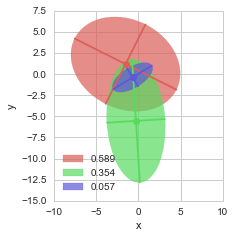

In [51]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [52]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.008      0.016  1.055630e-08      0.014       0.116

In [53]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuwNGddLvp0T8993e/360fiNkgkmB05pbBNVTzKwXJH
CjVqeSFbxdpgcbEk3EqOSSBgSaii2HEbCj0nkUOQKg+HwqMgRCk5IGCICAgk677WzJr7mvtMX88f
873verunu6e7p9daMyv9VH31fd9a3W/39HQ//bs+P07TNA0BAgQIcE3BX/UJBAgQIMBFIiC5AAEC
XGsEJBcgQIBrjYDkAgQIcK0RkFyAAAGuNQKSCxAgwLVGQHIBAgS41ghILkCAANcaAckFCBDgWiMg
uQABAlxrBCQXIECAa42A5AIECHCtEZBcgAABrjUCkgsQIMC1RkByAQIEuNYISC5AgADXGgHJBQgQ
4FojILkAAQJcawQkFyBAgGuNgOQCBAhwrRGQXIAAAa41ApILECDAtUZAcgECBLjWCEguQIAA1xoB
yQUIEOBaQ7jqEwhw9dA0DaIoQpZlhEIhhMNh8DwPjuOu+tQCBOgbnKZp2lWfRICrQ7vdRrlcxujo
KCRJAgCkUilMTk5idHQUPM8HpBdgqBFYci9gKIqCZrOJXC6HZDIJWZYRDoehaRo0TYOiKJBlGaIo
guM4hEKhgPQCDB0CknsBQtM0yLIMRVHAcRwURcHOzg4URYEgCFBVFY1GA9FoFIJwfosQ0mu32+B5
HqFQCKFQCIIgBKQXYGARuKsvMKiqCkmSQL72dDqNYrGItbU1RCIRiKKI09NTcBwHSZIgCAISiQTi
8TgSiQRCoZBuPbIOx3GU7ARB6NouQICrQmDJvUBA3E9FUQAAsizj+PgYqqoiHA5jdHQUoigiFosh
HA5jfHwcyWQS7XYbjUYD5XIZmUyGkh4hPpbMZFmGpmlot9vIZrOYn59HJBIJSC/AlSIguRcAVFWF
LMtQVRUcx6FareLk5ARTU1MYGxvD4eGhbnuO46BpGjiOQywWQywWw9TUFDRNQ6vVQrPZxNnZGU5P
TxEOhynhsaRXr9chiiIlPeLeBpZegMtGQHLXHCSORpIJp6enqFQqWF1dpZaa04gFx3GUzFjSazQa
ODs7QzqdRiQSQSKRgKZplFSB8zhgQHoBLhsByV1TqKoKRVGgqioAQBRFHB0dIRKJYHt7myYU+kkW
sKRHjkksPVVVcXR0hGg0SuN58XgcPN+pPw9IL8BlISC5awhVVZHP51Eul7G2toZSqYTT01PMzc1h
amqqi9iMlhxxV92C53kar6tUKlhcXKSZ2mKxiFarhWg0qnNv7UivVqthbGwM0Wg0IL0AnhGQ3DUD
cU+BDnEcHx+j2Wxic3MTsVisa/uLLPvgeR6xWAyJRAJAh3ybzSaazSYKhQLa7TZisRi19GKxmI70
stksBEGALMuBpRfAMwKSuyYw1r5JkoRarYaJiQlsb29T8rDaF7hYwgM6pJdMJpFMJgGck16j0UA+
n6ekRyw9kvwglqWVexuJRIIavQCWCEjuGsBY+5bP55HNZhGJRLC8vGy7rxk5eHVX3cJIeqQDg3Rh
yLKM09NTJJNJaun1SmSQ3tuA9AIQBCQ35CDWG9AhiZOTE8iyjIWFBVQqFUdrDEo9eCgUwsjICEZG
RgAAu7u7GBsbgyiKyGazkCRJZ+mZkZ4kSWi1WpT0OI5DOBwO3NsXMAKSG1IY3dNarYbj42NMTExg
bW0N9XrdEXlZWTx+EF+/a3Ach0QigYmJCQDnll6j0UAmk4Esy5T0EokEotFoF+ml02m6RmDpvTAR
kNwQgq19A4BMJoNSqYTl5WWMjo7S7bySjB8EcBEkYrT0ZFmmpHd6egpZlnXlKtFolJ6LlaUXkN71
R0ByQwRN01AoFBAOhxGLxSBJEo6Pj8FxHLa3txEOh+m2Th/ay4q/XQQEQcDo6Cgldpb0zs7OoCgK
TbhEo1FdgoIlPRLTI8QXkN71QkByQwLSmlUqlWic6uTkBDMzM5iZmel6KPslr2EkPjPSS6VS9G9F
UXRiAyzpqapKEzgs6QmCAEEQAtIbYgQkNwRQFIUKWgJAqVSCKIpYX1+nNWhewfapsj+7DiAERYhP
kiSdpaeqKiW8RCKhs+BY0pMkCdVqFfPz8wHpDSECkhtgGJMLrVYLtVoN0WgUN27csM0YDrMbelEI
h8MIh8MYGxsDAEiShEajgWaziWKxCE3TdJYeIT1ZltFoNKh7y3FcYOkNEQKSG1CwyiEAUCwWkclk
EIvFMD4+3rMkwinJsTEqt/sOO4ik1Pj4ODRN01l6xWIRABCPx6mQKGvxspZeQHqDjYDkBhBs7Zuq
qkilUmi1Wtjc3KQP3wsBfpWxOCEcjuMQiUQQiUR0pNdoNFCtVtFut7G3t2dq6QEB6Q0yApIbIBjd
00ajgaOjI4yOjtLWLDcWmhsJJfKAsnLn/cIPkroqcmBJLxwOo1gsYn5+Ho1GA/V6Hfl8HjzP60pW
rEgP6JS/kGJmtp4vwMUjILkBgbH2LZfLIZ/PY2lpCePj457WdEoymqZhf39fl1WMRCKQJElXluIG
1+kh1jSNXpNIJIKJiQk6xrHRaKBWqyGbzSIUCukSGawFp6oqstkskskkRkdHdUOBSGdGgItBQHJX
DE3TUK/XkU6nsba2BkVRqCz59vY2IpGIbnu3sbZeIK1fo6OjWFlZgSRJyGazEEURBwcHCIVC9KE1
m/Ew6HDqrroFx3GIRqOIRqOYnJzUkV61WqWkx0rFs4IDZpYeGQoUkJ6/CEjuCkGSC2QCFpEln5yc
xNzcXF/N87220zQNmUwG5XIZHMdhenoaiqIgEonQntCpqSm02200m01UKhVkMhlLufPrDCdEaUZ6
xmtH1JKB84SG0b0VRREAuoYCBaTnHQHJXRFY95RII52cnGBlZYW2LZnBTazNajuiEiwIAra3t/Hc
c8/R8zD+TWY8kAeXyJ2XSiWk02kqgmnUg7tO8BJbNLt2h4eHEAShaygQOwmNkBkZOmSceRuQnnsE
JHfJMNN9Oz4+hqZpuHHjhqPAfz/uaqVSse2U6LUmseCmp6ep3LmZHhwpubhq+OWu9rsGybiOjY3R
GRhEKr5cLuP09BSRSESXyLAivXQ6jcXFRd0ktID0rBGQ3CXCODWrXC4jlUphamrKcWbTa08q656a
dUr0K3cO6FVCyMhDNp43rOKWFxHXczMUiA0NcByHZrNJu2ACS683ApK7JLC1b5qmIZVKoV6vY2Nj
g5YoOIGXQl2je2okU7O+VxI7cgNWJaTZbGJ6ehqapjlqo3ohwI4s7YYCsaGBeDyus5ID97Y3ApK7
YJi1Zh0dHSEej2N7exuhUAiKoriqaXOTeHDqnl6EtUJKKkjDvLGNCoAu++i1XMUOl1lQ7Oc6rJVs
DA2Qkh+zoUAs6cmyHJAeApK7UBgb6wuFArLZLBYWFjA5OUl/7rZw103iIZ1O92zkv6gSCyPM2qhI
nVkul9M92KTk4qLO5SrQD1my16ZYLGJrawvtdhuNRqPnUCDAnPTa7TZGRkaufUdGQHIXAE3ToCgK
vvOd7+DGjRsAgFQqBVEUsbW1RcUcCdy6oL22Je4pAFP31GpNcqNfRu8q21FgLK4lJReqqqJQKGBk
ZORKy1UuqtbOC8j3YoyHWg0FsiO9/f19rK+v04JkUpzMWoTXAQHJ+QxjY329Xsfp6SnGxsawsrLS
c2qWk3osOxD3dHZ2Fs1m0xExDMINbVZntrOzg1Ao1Fe5yiBkeAn8IEu2oJiF3SS0XC4HURR1UvGx
WAyaptH7w8zSI8XJw056Acn5CGNrFmmuX15epvI+ZiA3rVOSM3twNU3D6ekpKpUKdU9PT08dP1jG
Na+aHMg1mZy

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARAAAADPCAYAAAA9FY5bAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnXtwE+fV/7+ybAX9JGFCyi0QAVZwAgTjCwmZBOiMCaXN
NCXB4AtEmTZO0nammcm1OAkYkji2p8T0nQkJnUJvcYeAY/5ImXbahkvjCdDUl1cOxjgGUWQwFzsJ
fiPJYNnS/v5wdpHl3dXuaqXV5XxmNJH22Wf3yGG/Os95zvMcHcMwDAiCIBSQprUBBEEkLiQgBEEo
hgSEIAjFkIAQBKEYEhCCIBRDAkIQhGLStTZACa2trVqbQBAcBQUFks/9X8dhBPyTBNsNBgMWLVqk
hlkxISEFBAAaqpo0ua/b44bFbNHk3mpD3yVyijevkHV+wD8J06w1gu1Xe16J1KSYoskQpr29HXa7
HQDQ2dmJ5cuXw263w263429/+5sWJhEEoYCYeyC7d+/GX/7yFxiNRgDAqVOn8JOf/ARPPvlkrE0h
CCJCYu6BWK1WvPPOO9znjo4O/Otf/8LGjRvx6quvwuPxxNokgiAUEnMPZPXq1bh48SL3OScnB+vX
r8c999yDXbt24d1338WmTZvCXsftcUfTzLi9t9rQdyEiQfMg6qpVqzBx4kTu/Ztvvimpn1bBPwo8
xifJ9F0SCc3zQMrLy/H5558DAE6cOIGFCxdqbBFBEFLR3APZtm0b3nzzTWRkZOA73/mOZA+EIAjt
0URAZs2ahYaGBgDAwoULsW/fPi3MIAgiQjQfwhAEkbiQgBAEoRgSEIIgFEMCQhCEYkhACIJQDAkI
QRCKIQEhCEIxmieSEUSq0X/jrNYmqAYJCEHEmHPMSsG2ObEzQxVoCEMQhGJIQAiCUAwJCEEQiiEB
IQhCMSQgBEEohgSEIBKEQCCAyspKlJSUwG63w+VyjWk/cuQIioqKUFJSwm2XIdTnq6++ws9//nNs
3LgRpaWl6OnpAQA0NDRg7dq1KC4uxtGjR8PaRNO4CU7319d5j2dPNsbYEiLaHDp0CD6fD/v374fD
4UBtbS127doFABgeHkZNTQ0aGxthNBpRVlaGwsJCtLW18fbZvn07HnnkETz88MP497//jXPnzsFo
NKK+vh4HDhzA0NAQNmzYgAcffBAGg0HQJhKQBCNUMGyL7uA/7+QFwWuQuCQmra2tWL58OQAgNzcX
HR0dXJvT6YTVakVmZiaA0Wp5zc3NcDgcvH3a2tpw11134cc//jFmzpyJ1157DSdOnEBeXh4MBgMM
BgOsViu6urqQk5MjaJMmAtLe3o63334b9fX1cLlcqKiogE6nw7x587B161akpdHIKhipoiH1HFZc
/H4d9L7rJCgJgsfjgdls5j7r9XqMjIwgPT0dHo8HFsvNTaVNJhM8Ho9gn97eXkycOBF//OMfsXPn
TuzevRtz5szhvYYYMX9Sd+/ejc2bN2NoaAgAUFNTg+eeew579+4FwzA4fPhwrE2Ka1jxsC26g3tF
CnudGbbbuHsIDYWI+MFsNsPr9XKfA4EA0tPTedu8Xi8sFotgn0mTJqGwsBAAUFhYiI6ODsFriKF5
YalTp07hvvvuAwCsWLECx48fj7VJcQn7UKslGkIECxN7TxKT+CQ/Px9NTaM1oR0OB7Kzs7k2m80G
l8uFgYEB+Hw+tLS0IC8vT7BPQUEBPvnkEwBAc3Mz7rzzTuTk5KC1tRVDQ0Nwu91wOp1j7sGH5oWl
GIaBTqcDMOoyud3SigMla2Gpi9d13PsZttsk/z2UEnz9qXNGq8Zfdn6F0/2jrussIxPV+6tJsheW
WrVqFY4dO4bS0lIwDIPq6mocPHgQg4ODKCkpQUVFBcrLy8EwDIqKijBt2jTePgCwadMmbN68Gfv2
7YPZbEZdXR0yMzNht9uxYcMGMAyD559/HrfccouoTZoHUYPjHV6vlysyFY5kKyzF/urr9dJiHGrg
drt5XVRL7ugx58kLuOwbPRbvcZJUKCyVlpaGN954Y8wxm83GvS8sLOSGJWJ9AGDmzJn4wx/+MO54
cXExiouLJdukuYAsWLAAn332GZYuXYqmpibcf//9WpsUM4KHCrESDTmwNjlPXkD31xRsJcajuYBs
2rQJW7ZswY4dO5CVlYXVq1drbVLU4IstxKNwhMLayM7ekJAQLJoXlpo7dy7+/Oc/a2FGVBEKRCaC
YAhhW3QHeSPEGDT3QJIJJfkaiQaJSOSc81wUbJsTOzNUgQREBeI9lqE2JCKRMeB/QGsTVINSPiMg
OGci2vka8QYXF6GckZSGPBCFBAtHPHHSfU20fZHlVtXuxXoiROpCAiKTi9dH148A8SUewcJhmzed
9xznmStjzpujwv9+26I70H3yAg1lUhQSEBnEm9chRTSCCT7HeeYKzvqHkO4eUcUroXhIakIxEImw
4sEuQNMaVjxs86ZLEo9QbPOm4/aZE8dcSykUD0ldSEAkEE+ex0n3tTHiESnsNdQSESK1oCFMGOJN
PAB1hCMYTkTOXAGgPNBK8ZDUgwREhHgQD7lxjkiwzZvOBVojiYtQPCR1oCFMGGItHuwQJXSoEm3x
YIl0SEPxkNSCPBCNEHpAYyUUYkQ6pKFM1dSBBEQAdjcwNQkVjXgQCzEiGdJQkllqQAISA2IZx2Bp
9/bzHl9smiLrOpGKCG0BkNyQgESZaM2c8BEqGtmzp4753O3q486RIyRqeCI0nElOKIgaRbQQj+zZ
U7lXKMHH2739OMN4x50jRCTBVQqsJi/kgUSJk+5rMfc6+ESDD/a80+cuy/JIIvVEANrVLNkgDyQK
xFo8hDyOcMyaah7jkUiBpnmJYOLGA3nssce4ClqzZs1CTU2NxhbFL0q8DjGyZ0/l4iPR9kQAiosk
E3EhIENDQ2AYBvX19VqbwpE92YjukxdkT+VG0/tQWziC4TwRVx+A8EMaVkSUksoicnpA5O/2/2Jn
hxrEhYB0dXXh+vXrePLJJzEyMoIXXngBubm5WpsVF4SbWVEbud5IJGnvqSoipsB8rU1QjbgQkAkT
JqC8vBzr16/H+fPn8fTTT+Pvf/87V/eTj1hUIfP7dbyV4cSqxY34/RFXkwudHZk19WZxZLW/N9/1
ZtxmxMU+D9q+uYJ5OpNg36nTTbjU+w3+d+BL3KkXr2AmeI05k7hKeJFWwUv2ynTxSFwIyNy5czF7
9mzodDrMnTsXkyZNQn9/P2bMmCHYJxZVyPS+6+MqtwlVcwNGf43vunum4vux3oYeelU9DYdvdFiS
axh7TbFqbvO/Pd4dZkhz190WOM9cwXko35jIkmuB8+QFWMzKvZBUqEwXj8TFLExjYyNqa2sBAFev
XoXH48GUKfIyJhOZdm9/xDMqoTh8fdxr/swpY47JQYotquxL8m1xb0KYQCCAyspKlJSUwG63w+Vy
jWk/cuQIioqKUFJSwtVdCtfn4MGDKCkp4T5XVVVh7dq1sNvtsNvtYb3puPBA1q1bh1deeQVlZWXQ
6XSorq4WHb4kE8HCoQbBAsEKR+h7R+/oOX69HwUI/6udPXsq2l19YWMikW4DANBWAGIcOnQIPp8P
+/fvh8PhQG1tLXbt2gUAGB4eRk1NDRobG2E0GlFWVobCwkK0tbUJ9uns7ERjYyMY5ubQ8dSpU9iz
Zw8mT54syaa4eEoNBgPq6uq0NiPmtHv7ozJUCRYLPtj2jp4rcPj6xg1thBALrKqxlwgtwBOntbUV
y5cvBwDk5uaio6ODa3M6nbBarcjMzAQAFBQUoLm5GQ6Hg7fPtWvXsGPHDrz66qvYsmULgFFvxeVy
obKyEl9++SXWrVuHdevWidoUF0MYInLYoUo48Qhm9q0mzJ85RdLQRkrCmVrbI9JQhh+Px8PlSgGA
Xq/HyMgI1xY

In [54]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


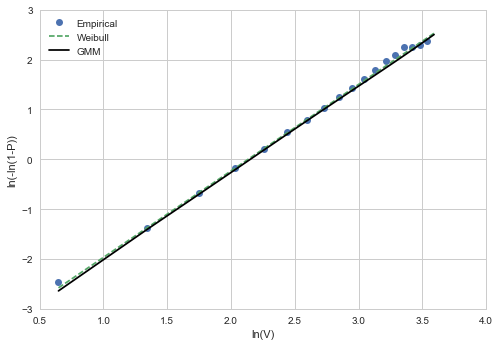

In [55]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y_cdf_gmm = array(list(zip(*y_))[0])

plot(log(x), log(-log(1-y_ecdf)),'o', label = 'Empirical')
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')
plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label = 'GMM')
plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Speed Distribution Comparison


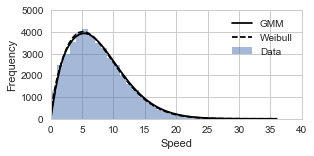

In [56]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y_gmm = array(list(zip(*y_))[0])*len(df.speed)/0.02

# 2. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)

df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')
plot(x, y_gmm,'-', color='black', label='GMM')
plot(x, y_weibul*len(df.speed), '--', color='black', label='Weibull') 
print('Speed Distribution Comparison')
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)

Direction Distribution Comparison


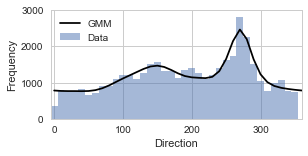

In [57]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

In [58]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

0.922150934025


## 5.3 Sectoral Comaprison

In [59]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        # 1. Get Weibull and ECDF
        x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed)
        # 2. Get GMM PDF, CDF
        _, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)
        
        # 3. Make Plots
        fig = plt.figure(figsize=(13,1.3))
        # 3.1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')                  
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 3.2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3.3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt.gca().set_xlim(right = log(max_speed+1))
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        
        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'], bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                            for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob, 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle))
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: divide by zero encountered in log


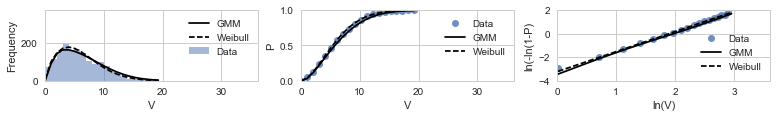

5.0 (-5.0 - 15.0) degree
data size: 1537 weight 0.03584672435105068
GMM Weibull
R square 0.958102703723 0.972792319275
max diff: 0.045949764251 0.0159755626768 speed value: 7.09947368421 y gmm 0.622885629373
 


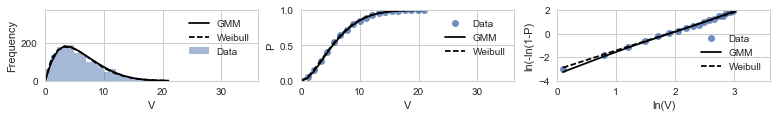

25.0 (15.0 - 35.0) degree
data size: 1557 weight 0.03631317489563169
GMM Weibull
R square 0.978910270992 0.982160329388
max diff: 0.0345263289921 0.0191227477958 speed value: 5.52105263158 y gmm 0.514606618985
 


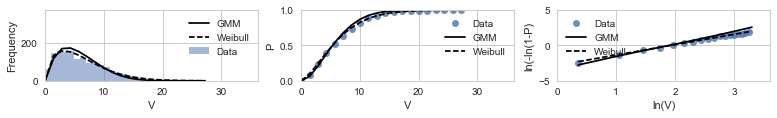

45.0 (35.0 - 55.0) degree
data size: 1479 weight 0.03449401777176575
GMM Weibull
R square 0.942848582822 0.983700541561
max diff: 0.0563208349919 0.0203871588935 speed value: 8.59894736842 y gmm 0.789924621334
 


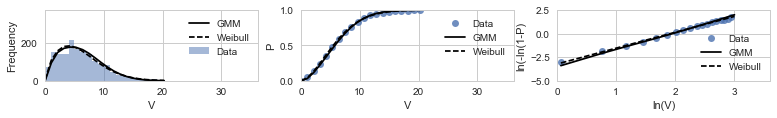

65.0 (55.0 - 75.0) degree
data size: 1638 weight 0.038202299601184785
GMM Weibull
R square 0.948890040367 0.955377978344
max diff: 0.0286356372547 0.0200513220253 speed value: 2.13263157895 y gmm 0.116053007434
 


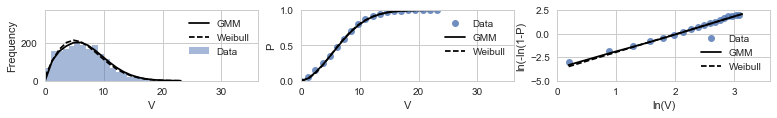

85.0 (75.0 - 95.0) degree
data size: 2006 weight 0.046784989621475384
GMM Weibull
R square 0.971516243856 0.959215277563
max diff: 0.0311557159277 0.0419637725361 speed value: 2.43052631579 y gmm 0.118395630034
 


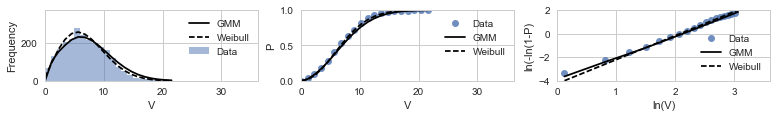

105.0 (95.0 - 115.0) degree
data size: 2425 weight 0.05655712853044756
GMM Weibull
R square 0.969257184549 0.980413335799
max diff: 0.0524903259744 0.0281057923379 speed value: 11.3263157895 y gmm 0.830808643098
 


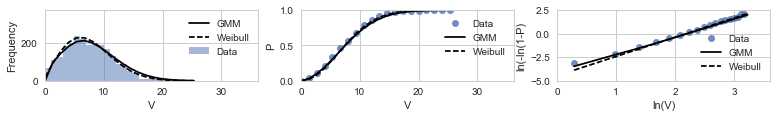

125.0 (115.0 - 135.0) degree
data size: 2379 weight 0.05548429227791123
GMM Weibull
R square 0.974502985574 0.979721026595
max diff: 0.0455868080293 0.0346109742482 speed value: 10.6652631579 y gmm 0.743820505968
 


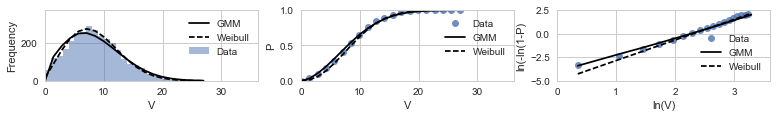

145.0 (135.0 - 155.0) degree
data size: 3075 weight 0.07171677122933041
GMM Weibull
R square 0.967740764316 0.986889926896
max diff: 0.0299059680868 0.0355229968442 speed value: 7.09473684211 y gmm 0.433158000607
 


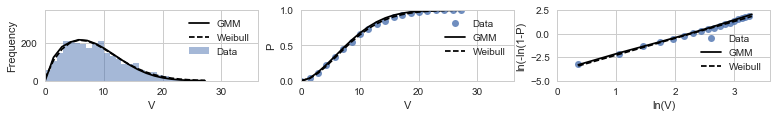

165.0 (155.0 - 175.0) degree
data size: 2640 weight 0.061571471884693425
GMM Weibull
R square 0.962040396494 0.970463873736
max diff: 0.0373131178514 0.0206621205356 speed value: 14.3210526316 y gmm 0.889207057245
 


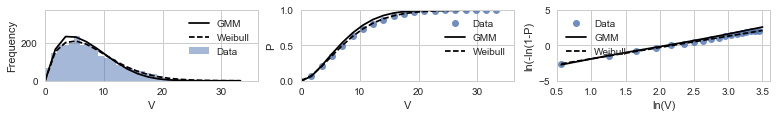

185.0 (175.0 - 195.0) degree
data size: 2469 weight 0.05758331972852578
GMM Weibull
R square 0.958543456134 0.986006254649
max diff: 0.0596605140673 0.0131399975281 speed value: 13.9957894737 y gmm 0.923978051532
 


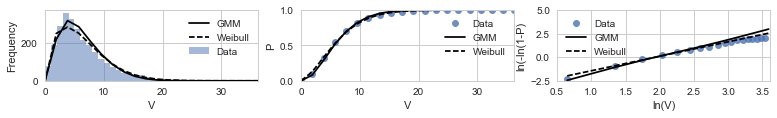

205.0 (195.0 - 215.0) degree
data size: 2651 weight 0.06182801968421298
GMM Weibull
R square 0.977125928976 0.966761878639
max diff: 0.0406844236786 0.0339626522105 speed value: 5.73157894737 y gmm 0.514577741542
 


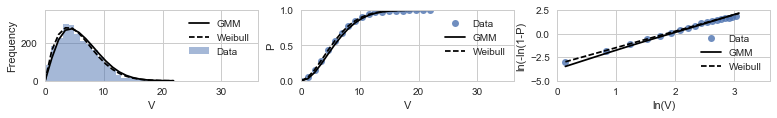

225.0 (215.0 - 235.0) degree
data size: 2306 weight 0.05378174779019054
GMM Weibull
R square 0.97731225347 0.989858637778
max diff: 0.0508321634899 0.0180779775589 speed value: 4.60210526316 y gmm 0.380217272763
 


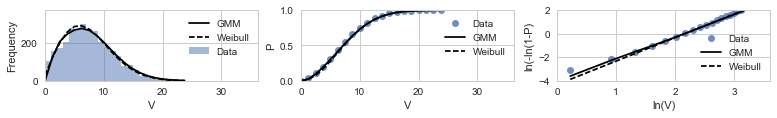

245.0 (235.0 - 255.0) degree
data size: 3023 weight 0.07050399981341979
GMM Weibull
R square 0.970849632399 0.97654386874
max diff: 0.0211122999384 0.0326616874437 speed value: 8.74263157895 y gmm 0.637835764898
 


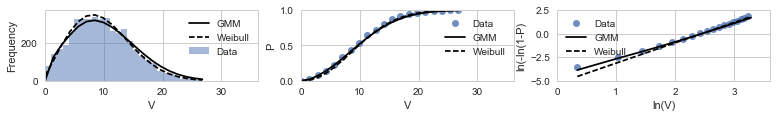

265.0 (255.0 - 275.0) degree
data size: 4547 weight 0.1060475313104928
GMM Weibull
R square 0.971778096574 0.978635614967
max diff: 0.0392603240349 0.046646394549 speed value: 15.4926315789 y gmm 0.829224391162
 


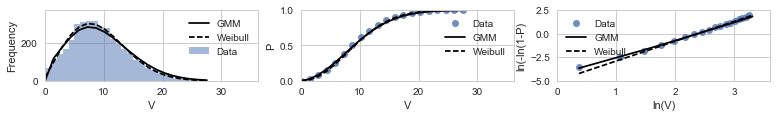

285.0 (275.0 - 295.0) degree
data size: 3769 weight 0.08790260512629149
GMM Weibull
R square 0.971275902785 0.982940913149
max diff: 0.0304414857447 0.0344101313671 speed value: 11.5957894737 y gmm 0.679030522746
 


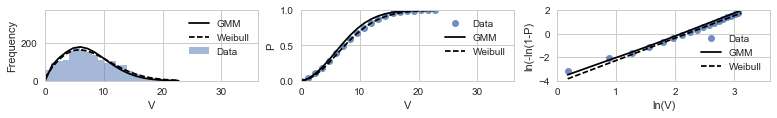

305.0 (295.0 - 315.0) degree
data size: 1808 weight 0.042167129230123376
GMM Weibull
R square 0.920391227983 0.958324503309
max diff: 0.0690712962467 0.0374849518975 speed value: 10.7668421053 y gmm 0.816305809521
 


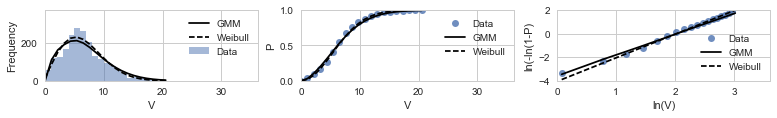

325.0 (315.0 - 335.0) degree
data size: 2064 weight 0.04813769620076031
GMM Weibull
R square 0.907289489662 0.937780996222
max diff: 0.0487594407924 0.0457947446077 speed value: 7.56368421053 y gmm 0.629050636727
 


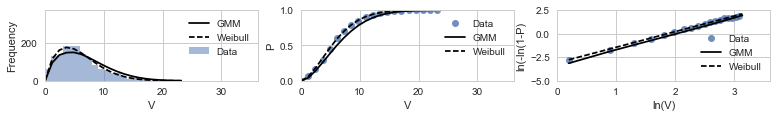

345.0 (335.0 - 355.0) degree
data size: 1505 weight 0.035100403479721064
GMM Weibull
R square 0.933413169458 0.982616491486
max diff: 0.0990033159633 0.0204201387725 speed value: 7.31684210526 y gmm 0.611295687359
 
Wall time: 1min 5s


In [60]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

0.9619208713287065 0.9750229389203451


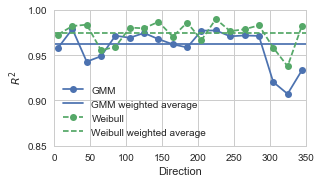

In [61]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

0.043081780349471265 0.030633470898755528


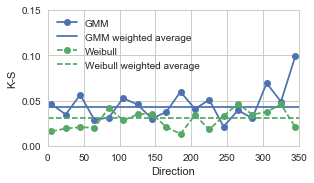

In [62]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

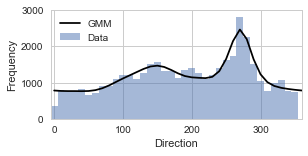

In [63]:
# Compare direction weight with previous figure
display(dir_fig)

## 5.4 Insufficient-fit Sector Investigation

### 5.4.1 Data Variability, by Bootstrap (Resampling)

In [64]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [65]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
# weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


345.0 (335.0 - 355.0) Degree Speed Distribution
0.105128509113 7.5 0.626432952681


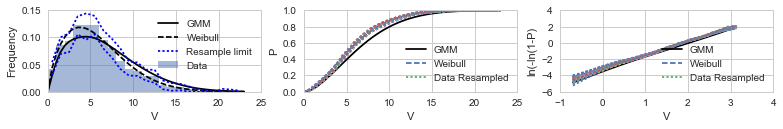

In [66]:
x = arange(0, sub_max_speed, 0.5)
_, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed, x)
_, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)

fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_cdf_gmm,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color = 'black',label='GMM')

# 3. Weilbull 
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_cdf_weibull,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_cdf_gmm)
print(diff.max(), x[diff.argmax()], y_cdf_gmm[diff.argmax()])

### 5.4.2 Time Variability

In [67]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

ax2.plot(x, y_cdf_gmm,'-', color='black', label = 'GMM')
ax2.plot(x, y_cdf_weibull,'--', label='Weibull')

ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black',label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log


345.0 (335.0 - 355.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsnXl4HNWV9t+q6k17a2lJli1ZsmxhCHgMDgFj7IQ1xAkh
w2q2AQIhkAUIEwghBBzGMQTITBgCBpIBB4aAgY+ZQAJ2xmCWAAm2wWBhYxtZli1b6kVrr7V/f7Ru
ubp6X9Ut3d/z8GCV1FXVXV33rXPuOe9lVFVVQaFQKBQKJSHsZJ8AhUKhUCilABVMCoVCoVBSgAom
hUKhUCgpQAWTQqFQKJQUoIJJoVAoFEoKUMGkUCgUCiUFqGBSKBQKhZICVDApFAqFQkkBKpgUCoVC
oaQAFUwKhUKhUFKACiaFQqFQKClABZNCoVAolBSggkmhUCgUSgpQwaRQKBQKJQWoYFIoFAqFkgJU
MCkUCoVSMA4cOIAbbrgBF154If7lX/4F1157Lfbs2YOHHnoIRx55JJxOp/a3Q0ND+MIXvoCXXnoJ
/f39OOKII/D4449H7O+6667D5ZdfXpBzp4JJoVAolIIQDAZx/fXX46qrrsLzzz+Pp556Cj/4wQ9w
9913AwDa29vx2muvaX//6quvYsaMGdrPbW1t2LBhg/bzyMgI+vr6Cnb+poIdiUKhUChFwy233IIX
Xnghp/u84IILcP/998f9/aZNm3DiiSfi2GOP1bYtWLAATz31FH77299i+fLlWL9+Pa688krt7085
5RTtb2tra2G329HT04POzk689tprOOuss7Bly5acvo940AiTQqFQKAWhv78fbW1t2s/XX389Lr/8
cpx11lkYHBxEQ0MDysrKcODAAfT19aG5uRlWqzViH1//+tfxl7/8BQDw+uuv4/TTTy/Y+dMIk0Kh
UKYh999/f8JoMB80Nzeju7tb+3nNmjUAgAsvvBCyLAM4LIiSJOHss8/Gu+++G7GP008/HZdeeinO
PfdcOBwO2Gy2gp0/jTApFAqFUhBOO+00vP/++9i2bZu2ra+vD4ODg2AYBgDw1a9+Fa+//jq2bNmC
E044IWofFRUV6OjowP33349vfOMbBTt3gAomhUKhUApERUUF1qxZgz/84Q+47LLLsGLFCtx+++34
6U9/ipaWFgBAVVUVmpubcdRRR4FlY0vU2Wefja1bt2Lx4sWFPH0wqqqqBT0ihUKhUCglCI0wKRQK
hUJJASqYFAqFQqGkAK2SpUxLFEWBJEkQBAEcx4FlWXAcB47jtOIDCoVC0UMFkzKtUBQFTqcTtbW1
2s+qqkJVVfj9fni9XrS0tIBlWTAMQ4WUQqFoUMGkTAsURYEsy1AUBQMDA7Db7VAUBaIowmw2a2JI
BJT0hJGaOIZhNAGlQkqhTE+oYFKmNCT1qi8GV1UVbrcbw8PDYBgGsizDYrGAZVlIkgS/3w+LxQKT
yRQhhqkKqclk0n6mUChTB1r0Q5mSyLIMQRAgCIImbpIkaSshCIKAjo4OdHR0YM6cOWhsbITVaoWq
qhgZGcH+/fvR09OD/fv3Y3BwECMjI/D7/Zr4EqEEDgupJEngeV5L7fp8PgQCAQSDQfA8D1mWQbu4
KNOZK664Ap988gmA8D24aNEi/P73v9d+f/nll2Pnzp1Rr3v77bexbt069Pf348ILL0z5eEuWLNH2
29PTk+XZ0wiTMsWQZVlLvRJRkyQJHo8HIyMjqK6uBsuymDFjBjiO04p+ysrKoKoqeJ7HrFmztH3x
PA9BEMDzPHw+nybAVqsVFosFFotF+3eyiJTneQAAy7JaBErSujQipUwHlixZgi1btmDBggXYunUr
Tj75ZLz11lu45pprwPM8Dh48iPnz50e9btmyZQDCXrSTCRVMypQgllCKogiPx4PR0VHU1NSgs7MT
FosFXq83IqUaD47jUF5ejvLy8ojtpLqWiKnP5wPP82AYJkJAyb+N85x6IRVFUYtYybyo/t9USCn5
pL09etvFFwP33JPZ7/ftS3y8k046CY888gi+/e1v46233sIFF1yABx54AF6vF59++im+9KUvYfPm
zfiP//gPcByH1tZW3H333XjllVewd+9erFixAsPDw7juuuswNDSEr3zlK/j+97+P2267DcuXL8ey
Zcvw9ttv49VXX8W9996b3oeRAlQwKSVNLKEUBAEejwdjY2Ow2+2YO3cuzGZz0n0xDJNSytRkMsFk
MkUIKRFBIqKhUAjj4+MQBAEMw2giqhdTIo761K4kSdq/iZDqhVOW5ZgiTKGUAkcddRT27t0LVVWx
efNm3HzzzVi8eDHee+897Nq1CyeffDJ+/vOf449//CPq6+vxm9/8Bv/zP/8Dk+mwVAUCAdx///0o
Ly/HpZdeitNOO61g508Fk1JyqKoaUfWqF0q3243x8XHU1tZi3rx5ETcaIVVhTAeGYTQhraioiDhX
MrcpCAKCwSBGR0e1VLBeRMn/iTjqK3cVRQEAfP7552hvb9cKi4zFRvrXUSjJSBYRZvt7IyzLYv78
+Xj77bfhcDhgsViwbNkyvPnmm/jss89w6aWX4uc//zluuukmAEAoFMJJJ52E2bNna/uYP38+qqqq
AADHHHMMent7I46RzzoBKpiUkiGeUPI8D7fbDa/Xi7q6urhCSYgnmPkSUrPZHBXhqqoKURS1wqRA
IKAJqclkipofJUJK9glECqk+xRxvjpRCKQaWLFmCxx57DF//+tcBAIsWLcIjjzwCILxAdHNzMx55
5BFUVVXh9ddfR3l5OQYGBrTX9/T0wO/3w2q14pNPPsFFF12E999/H263GwCwY8eOvJ07FUxK0UOE
0lihyvM8XC4XfD5fSkJpZDIjMTLfabFYIrYTIdXPjwqCAFEUYTKZoCgKhoeHYbPZtNcbo0q9kAqC
oB3PKKTGIiUKpRCcdNJJuOOOO3DfffcBACwWC6qqqnDkkUeCZVn87Gc/w7XXXgtVVVFRUYH77rsv
QjBramrwox/9CMPDw1i+fDnmzp2LCy64ALfffjteeeUVtMeaeM0RdLUSStFC5gVJOwYZ3EOhENxu
N3w+H+rr61FfXw+O41Le7549e9Da2gqbzaYJCgDwPI+BgYG83nCZoqoqBEHA/v37YbfbNVGVJAlm
szkqtas3Y4i3PyBaSE0mE50fpVDiQCNMStERSygZhkEwGITb7UYgEEB9fT1aWlrSEkpCPlKv+YYU
DjEMg7q6Ou19E7ciEpGSQiMipMb5USKk6USk1NWIQglDBZNSNKiqqjX719TUaAN7IBCA2+1GMBhE
Q0MDZs2alfWcXKHmMPMNy7KwWq2wWq0R2xVFiWh9IfOjxNXI2PoSq2CICKn+MyHpXGoPSJmOUMGk
TDr6iDIQCGB8fBx2ux2BQAAulwuhUAgOhwOtra05KV6ZDoM7y7Kw2Wyw2WwR2/UOSDzPIxAIgOd5
KIoSs/Ul1jyn0R6QHI+kdUVRhM1mS5oWplBKDSqYlEkjVuqVZVmIooje3l4IggCHw4G2tracVnkW
skq22CCuRmVlZRHbiZAai41UVY3Z+pLIjGHfvn1oaWnRUsjUsJ4yVaCCSSk48Yp5fD4fnE4nBEFA
S0sL7HZ7XgZWvTBOB5FMhXhCmszVyCimHMdFXFO68gtlKkEFk1Iw9CblwOHUqNfrhcvlgizLqK6u
RiAQ0NarLCRUPKPJxNVI3/qSSkQaL7VLV36hFBtUMCl5h5gNkAGSCNP4+DjcbjcURUFjY6MmloFA
IK/nQ4UxO5K5GvX19cFkMiEUCmFsbCwlVyP9PqhhPaVYoYJJyRt6Vx6SplNVFWNjY5orh8PhQHV1
tTbwFULMpvMcZj4hrkYMw8But2smEolcjTiOi1lslEhIjYb1xvYXKqSUfEEFk5JzYgklAIyOjsLt
doNlWTQ2NqK

### 5.4.3 Adjacent Sector Variability

In [68]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [69]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


345.0
GMM, Weibull, Histogram


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmYXGWZ/n/XqbW7qvd9TS9JCCG0YJAAYTIwAkE0ozM/
iBAMCBox4wwERxEj4ILDkggGl+AMjAugRDKgRmVRoyEI+SKIEgEDodPppJPuWrqrqms9+++Pynty
6tSp6tpOdXX1+7kuLpLqznlPbec+z/M+z/2YZFmWQaFQKBQKJSPMbJ8AhUKhUChzASqYFAqFQqFk
ARVMCoVCoVCygAomhUKhUChZQAWTQqFQKJQsoIJJoVAoFEoWUMGkUCgUCiULqGBSKBQKhZIFVDAp
FAqFQskCKpgUCoVCoWQBFUwKhUKhULKACiaFQqFQKFlABZNCoVAolCyggkmhUCgUShZQwaRQKBQK
JQuoYFIoFAqlZBw9ehQ33ngj1q5di2uuuQaf+tSncPDgQXz729/GqaeeCrfbrfzu5OQkTjvtNDz1
1FMYGxvDKaecgv/5n/9JOt6nP/1prF+/viTnTgWTQqFQKCUhFoth48aNuO666/DEE0/gkUcewb//
+7/ja1/7GgCgr68PzzzzjPL7Tz/9NDo6OpS/9/b24rnnnlP+7vf7MTo6WrLzt5RsJQqFQqGUDZ//
/Oexc+fOoh7ziiuuwNatW9P+/A9/+APOOeccnHnmmcpjQ0NDeOSRR/Cd73wHl112GZ599ll8/OMf
V37/wgsvVH63oaEB9fX1GB4exuDgIJ555hlceumlePXVV4v6PNJBI0wKhUKhlISxsTH09vYqf9+4
cSPWr1+PSy+9FBMTE2hubkZVVRWOHj2K0dFRtLe3w263Jx3jgx/8IH79618DAHbv3o2LLrqoZOdP
I0wKhUKZh2zdujVjNGgE7e3teOONN5S/P/jggwCAtWvXQhRFACcFURAErFmzBi+++GLSMS666CJc
ffXV+Nd//Ve0tLTA4XCU7PxphEmhUCiUkvD+978f+/btw1//+lflsdHRUUxMTMBkMgEAVq9ejd27
d+PVV1/FihUrUo7hdDrR39+PrVu34kMf+lDJzh2ggkmhUCiUEuF0OvHggw/iRz/6ET72sY/hyiuv
xObNm/HFL34RnZ2dAICamhq0t7dj6dKlYBh9iVqzZg3+/Oc/49xzzy3l6cMky7Jc0hUpFAqFQpmD
0AiTQqFQKJQsoIJJoVAoFEoW0CpZyrxEkiQIggCO42A2m8EwDMxmM8xms1J8QKFQKGqoYFLmFZIk
we12o6GhQfm7LMuQZRmRSAShUAidnZ1gGAYmk4kKKYVCUaCCSZkXSJIEURQhSRLGx8dRX18PSZLA
8zysVqsihkRASU8YqYkzmUyKgFIhpVDmJ1QwKRUNSb2qi8FlWYbX68XU1BRMJhNEUYTNZgPDMBAE
AZFIBDabDRaLJUkMsxVSi8Wi/J1CoVQOtOiHUpGIogiO48BxnCJugiAokxA4jkN/fz/6+/sxMDCA
1tZW2O12yLIMv9+PI0eOYHh4GEeOHMHExAT8fj8ikYgivkQogZNCKggCWJZVUrvhcBjRaBSxWAws
y0IURdAuLsp85tprr8X+/fsBJL6Dy5cvx8MPP6z8fP369fj73/+e8u/27t2Ln/70pxgbG8PatWuz
Xm/lypXKcYeHhws8exphUioMURSV1CsRNUEQ4PP54Pf7UVtbC4Zh0NHRAbPZrBT9VFVVQZZlsCyL
7u5u5Vgsy4LjOLAsi3A4rAiw3W6HzWaDzWZT/jxTRMqyLARBgN/vR0dHB0wmk5LWpREpZT6wcuVK
vPrqqxgaGsKf//xnnH/++Xj++efxyU9+EizL4tixY1iyZEnKv1u1ahWAhBftbEIFk1IR6Aklz/Pw
+XwIBAKoq6vD4OAgbDYbQqFQUko1HWazGdXV1aiurk56nFTXEjENh8NgWRYmkylJQMmf1fucpLiI
CCnP80rESvZF1X+mQkoxkr6+1Meuugq4++78fn74cOb1zjvvPGzfvh3XX389nn/+eVxxxRX4xje+
gVAohDfffBNnn302XnnlFXzzm9+E2WxGT08Pvva1r+GXv/wlDh06hCuvvBJTU1P49Kc/jcnJSVxw
wQX4zGc+g1tvvRWXXXYZVq1ahb179+Lpp5/GPffck9uLkQVUMClzGj2h5DgOPp8PwWAQ9fX1WLhw
IaxW64zHMplMWaVMLRYLLBZLkpCSaJKIaDwex/T0NDiOg8lkUkTUbDYrBUhEHNViKgiC8mcipGrh
pEJKmcssXboUhw4dgizLeOWVV/DZz34W5557Ll566SW8/fbbOP/883H77bfjJz/5CZqamrBt2zb8
7Gc/g8VyUqqi0Si2bt2K6upqXH311Xj/+99fsvOngkmZc8iynFT1qhZKr9eL6elpNDQ0YNGiRUlf
NEK2wpgLJpNJEVKn05l0rmRvk+M4xGIxSJKEQ4cOwWw2J0Wk5P9EDNWVu5IkKccj6zEMk1JspP53
FMpMzBQRFvpzLQzDYMmSJdi7dy9aWlpgs9mwatUq7NmzBwcOHMDVV1+N22+/HZs2bQIAxONxnHfe
eViwYIFyjCVLlqCmpgYAcPrpp2NkZCRpDSPrBKhgUuYM6YSSZVl4vV6EQiE0NjamFUpCOsE0Skit
VqsS4XIch2PHjqGvrw88zyuFSdFoFIFAABzHwWKxpOyPqoWUkElII5EIqqqq4HA4lIiUQikHVq5c
if/+7//GBz/4QQDA8uXLsX37dgCJAdHt7e3Yvn07ampqsHv3blRXV2N8fFz598PDw4hEIrDb7di/
fz8++tGPYt++ffB6vQCAt956y7Bzp4JJKXuIUGorVFmWhcfjQTgczkootcxGJEZEmex32my2pJ/L
sgye55P2RzmOA8/zsFgsKdGozWZLiSolScLk5CQaGhrSRqRmszmlSIlCKQXnnXcebrvtNmzZsgUA
YLPZUFNTg1NPPRUMw+BLX/oSPvWpT0GWZTidTmzZsiVJMOvq6nDzzTdjamoKl112GRYuXIgrrrgC
mzdvxi9/+Uv06W28Fgk6rYRStsiyjFgshmAwiIaGBuXiHo/H4fV6EQ6H0dTUhKamJpjN5qyPe/Dg
QfT09MDhcIDjOOVxlmUxPj5u6BeO53kcPXoUAwMDOf07WZaVaFRduSsIAqxWa0pq1+12o7GxMSk9
rD0ekCqkFouFmjFQKGmgESal7CAFNKIoIh6Pw+/3o7GxEbFYDF6vF9FoFE1NTejs7MxJKAlGpF6N
hhQO2e12Zf8GgOJWRESUFBrxPA+3242qqqokMSWuRulSu+QGQi2k1NWIQklABZNSNqiFUt1qIYoi
RkdHEYvF0NzcjO7u7oL35Eq1h2k0DMMoQqrm6NGjcLlcYBgGHMcp+6PE1Ujb+qJXMESEVP2akHQu
+V2SWqZCSpkPUMGkzDp6QmkymRCNRjExMQGO49DU1ISenp6iFK/M9sW9VKJss9lSUrJqBySWZRGN
RsGyLCRJ0t0f1dvnJD2koihieHgYixYtSqnYpREppRKhgkmZNdIJZSQSgcfjAcdxaGhoAM/zaGpq
Ktq6payS1VujVOitRVyNqqqqkh4nQqotNpJlWbf1RRtlUsN6ynyACial5OgJJQCEw2F4PB4IgoCW
lhbU19eD53n4/f6irq8WxrmYhjWCdEKaydXIarVClmUEAgFdVyMge8N6KqSUuQAVTErJUJuUAycj
oFAoBI/HA1EU0drairq6OuVnpRQ0Kp6pZHI1isVimJiYSOtqpBeRao9B/kzQM2OgrkaUcoEKJsVw
iNkAuUASYZqenobX64UkSWhtbUVtbW3KhdEoMwEqjPlD2k+qq6thMpnQ3t4O4KSrEYlI4/E4gsGg
YnCfydWIoGd

# 6. Result Variability & Cross-Validation

In [70]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.583  -1.487   1.096  6.462  5.532  -0.194
2  0.364  -0.339  -5.483  3.466  7.410  -0.141
3  0.053  -0.554  -0.293  2.252  1.674   0.595

GMM Plot Result
0.582621984262 [[-1.48650612  1.09553227]] [ 5.22265507  6.71418788] -115.605017663
0.364087576738 [[-0.33907587 -5.48299823]] [ 3.42207417  7.43032715] -175.19365667
0.0532904390008 [[-0.55401284 -0.29312661]] [ 1.19299698  2.5392018 ] -58.4197104113


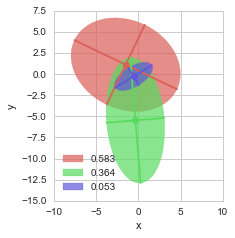

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.008      0.014  1.118778e-08      0.015       0.119

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.008      0.016  1.086045e-08      0.015       0.117

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.610  -1.400   1.168  6.435  5.598  -0.207
2  0.335  -0.334  -5.782  3.385  6.916  -0.095
3  0.056  -0.628  -0.376  2.344  1.760   0.598

GMM Plot Result
0.609841748286 [[-1.40022899  1.16795766]] [ 5.23154892  6.73685807] -118.008073276
0.33452542776 [[-0.33396925 -5.78228868]] [ 3.36473453  6.92588731] -176.511596852
0.0556328239538 [[-0.62845774 -0.37638766]] [ 1.24688361  2.65243089] -57.9633639287


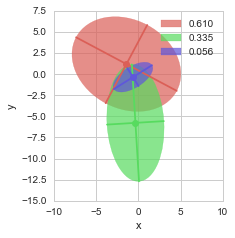

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.004959      0.016  1.095777e-08      0.015       0.118

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.007      0.017  1.091769e-08      0.015       0.117

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.599  -1.451   1.139  6.396  5.510  -0.216
2  0.344  -0.327  -5.750  3.458  7.286  -0.079
3  0.057  -0.555  -0.293  2.360  1.725   0.597

GMM Plot Result
0.599263298276 [[-1.45123508  1.1388455 ]] [ 5.13701363  6.6998229 ] -117.612103035
0.343800683137 [[-0.32674542 -5.75039601]] [ 3.44392512  7.2929834 ] -177.24144642
0.0569360185871 [[-0.55535417 -0.29303512]] [ 1.23199247  2.65069861] -59.0365452225


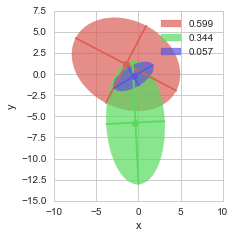

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.009      0.024  1.198477e-08      0.015       0.123

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.010      0.019  1.108652e-08      0.015       0.118

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.588  -1.448   1.348  6.426  5.542  -0.169
2  0.353  -0.218  -5.811  3.538  6.947  -0.089
3  0.059  -0.686  -0.433  2.273  1.736   0.583

GMM Plot Result
0.587981650959 [[-1.4477311   1.34789221]] [ 5.29057469  6.63479332] -114.365071772
0.353173446697 [[-0.21817288 -5.81104242]] [ 3.51916288  6.95615783] -176.515137132
0.0588449023438 [[-0.68600936 -0.43270866]] [ 1.24448735  2.57540996] -57.5383910128


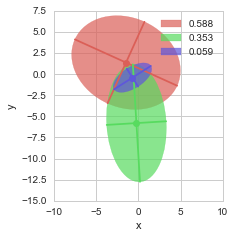

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.008      0.014  1.050050e-08      0.014       0.115

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.010      0.015  1.090019e-08      0.015       0.117

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.573  -1.544   1.202  6.469  5.452  -0.199
2  0.369  -0.206  -5.564  3.516  7.409  -0.092
3  0.058  -0.630  -0.302  2.270  1.759   0.596

GMM Plot Result
0.572742283681 [[-1.54407887  1.20163806]] [ 5.1479238   6.71358007] -114.60115571
0.369280962203 [[-0.20580929 -5.56373467]] [ 3.49702884  7.41840874] -176.774317298
0.0579767541156 [[-0.63001467 -0.30226796]] [ 1.2367507   2.59199576] -56.7023898736


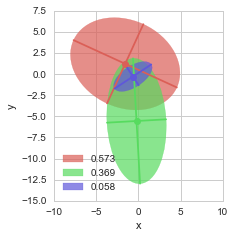

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.009      0.017  1.103026e-08      0.015       0.118

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.010      0.017  1.107990e-08      0.015       0.118

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.600  -1.421   1.403  6.306  5.490  -0.201
2  0.342  -0.340  -6.138  3.564  7.008  -0.138
3  0.058  -0.736  -0.449  2.238  1.792   0.599

GMM Plot Result
0.600183849687 [[-1.42137315  1.4025359 ]] [ 5.14806285  6.58773448] -117.637875479
0.341894055143 [[-0.33975038 -6.13845791]] [ 3.51839668  7.03122416] -174.65804312
0.05792209517 [[-0.73556044 -0.44905568]] [ 1.24289035  2.58377037] -55.2443612343


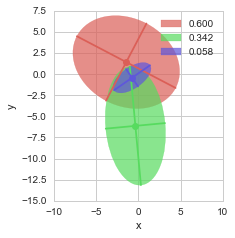

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.007      0.019  1.105099e-08      0.015       0.118

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.009      0.019  1.127073e-08      0.015       0.119

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.613  -1.537   1.105  6.372  5.552  -0.198
2  0.333  -0.209  -5.927  3.454  7.298  -0.109
3  0.054  -0.712  -0.440  2.326  1.672   0.604

GMM Plot Result
0.613059095615 [[-1.537335    1.10466597]] [ 5.21366684  6.65174485] -117.530429816
0.332707860523 [[-0.20891967 -5.92696585]] [ 3.42822188  7.3100119 ] -176.227602209
0.0542330438614 [[-0.71209412 -0.44043223]] [ 1.18937743  2.6058324 ] -59.5652768482


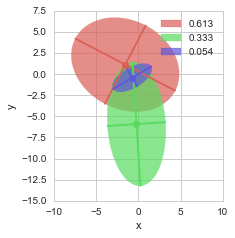

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.008      0.018  1.097962e-08      0.015       0.118

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.008      0.016  1.101976e-08      0.015       0.118

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.532  -1.713   1.569  6.647  5.416  -0.230
2  0.413  -0.210  -4.974  3.575  7.272  -0.088
3  0.055  -0.900  -0.604  2.484  1.781   0.637

GMM Plot Result
0.532288492988 [[-1.71324761  1.56932071]] [ 5.06407805  6.91890919] -114.05308313
0.413132206377 [[-0.21047949 -4.97430706]] [ 3.55641323  7.28072976] -176.746370447
0.0545793006353 [[-0.90000634 -0.60353725]] [ 1.21535297  2.80386327] -58.9973844457


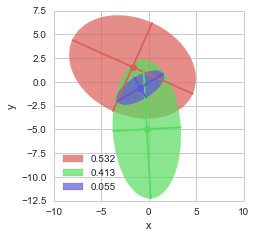

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.010      0.024  1.178355e-08      0.016       0.122

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.010      0.020  1.142116e-08      0.015       0.120

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.604  -1.568   1.211  6.388  5.610  -0.208
2  0.339  -0.283  -5.848  3.479  7.145  -0.107
3  0.058  -0.623  -0.306  2.203  1.701   0.591

GMM Plot Result
0.603820053431 [[-1.56835469  1.2105473 ]] [ 5.23050271  6.70246659] -118.939739493
0.338633739181 [[-0.28332865 -5.84827077]] [ 3.45307463  7.15761611] -176.105632286
0.0575462073882 [[-0.62269301 -0.30611405]] [ 1.2044487   2.50921161] -56.9260398157


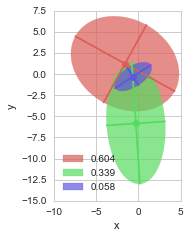

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.007      0.017  1.155227e-08      0.015       0.121

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.009      0.017  1.112658e-08      0.015       0.119

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.567  -1.469   1.126  6.551  5.516  -0.215
2  0.375  -0.289  -5.123  3.453  7.453  -0.112
3  0.058  -0.694  -0.398  2.350  1.734   0.607

GMM Plot Result
0.567086259527 [[-1.46920067  1.12616356]] [ 5.16789428  6.82891281] -115.61372608
0.375240270055 [[-0.28928032 -5.12298509]] [ 3.42581938  7.46598869] -176.236216521
0.0576734704179 [[-0.69398302 -0.3980958 ]] [ 1.22063516  2.6536906 ] -58.4696401116


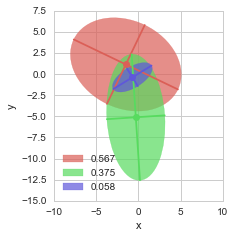

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.010      0.019  1.178842e-08      0.015       0.122

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.993  0.010      0.018  1.090811e-08      0.015       0.117


Wall time: 36.4 s


In [71]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [72]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

Number of train/test dataset 32157.75 10719.25
  
Number of gaussian 1
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.079606  0.047050  1.082487e-07    0.046117     0.370218  0.926115
1    0.075417  0.044054  1.017873e-07    0.045240     0.358251  0.930279
2    0.077358  0.045028  1.052433e-07    0.045743     0.364708  0.928146
3    0.075256  0.044470  1.017550e-07    0.045128     0.358856  0.930182

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.072740  0.045829  1.011511e-07    0.045798     0.356718  0.930508
1    0.090161  0.050431  1.102283e-07    0.046173     0.374719  0.925045
2    0.081570  0.043593  1.023359e-07    0.045243     0.359790  0.929692
3    0.088450  0.047084  1.159696e-07    0.047685     0.382227  0.921539

  
Number of gaussian 2
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.048218  0.011087  4.510911e-08    0.029889     0.238816  0.969173
1    0.060751  0.011763  5.014451e-08    0.031230     0.251693  0.965829
2    0.049305  0.010264  4.605502e-08    0.030139     0.241349  0.968302
3    0.068068  0.011080  4.340990e-08    0.029977     0.234247  0.970341

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.065739  0.013732  5.245616e-08    0.032584     0.257443  0.964069
1    0.059362  0.014055  4.062186e-08    0.029482     0.226820  0.971997
2    0.080783  0.012007  4.969161e-08    0.031912     0.250435  0.966673
3    0.050171  0.015903  5.815659e-08    0.032171     0.271168  0.960156

  
Number of gaussian 3
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.016626  0.008775  1.135463e-08    0.015049     0.119773  0.992240
1    0.016925  0.007786  1.049168e-08    0.014359     0.115225  0.992852
2    0.016678  0.008085  1.089940e-08    0.014701     0.117318  0.992524
3    0.015592  0.008895  1.056633e-08    0.014619     0.115605  0.992754

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.019285  0.009988  1.275115e-08    0.015893     0.127066  0.991266
1    0.021668  0.011099  1.653089e-08    0.018508     0.144328  0.988580
2    0.023348  0.008530  1.512846e-08    0.017466     0.138511  0.989755
3    0.024524  0.016607  1.733997e-08    0.018155     0.147931  0.988257

  
Number of gaussian 4
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.011134  0.006713  7.094284e-09    0.011943     0.094662  0.995153
1    0.009779  0.005495  6.376745e-09    0.011203     0.089797  0.995676
2    0.011409  0.006112  7.025818e-09    0.011814     0.094261  0.995149
3    0.010607  0.005981  7.099932e-09    0.011915     0.094741  0.995139

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.014850  0.007785  9.424560e-09    0.013503     0.109280  0.993537
1    0.019891  0.008784  1.325502e-08    0.016536     0.129386  0.990709
2    0.014069  0.011605  1.184016e-08    0.015406     0.122265  0.992138
3    0.014825  0.009044  9.514282e-09    0.013676     0.109657  0.993517

  
Number of gaussian 5
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.015193  0.005508  8.090194e-09    0.012672     0.101101  0.994490
1    0.011817  0.003639  9.033529e-09    0.013294     0.106918  0.993840
2    0.011040  0.004956  5.545420e-09    0.010566     0.083725  0.996184
3    0.009897  0.006306  5.643532e-09    0.010653     0.084444  0.996132

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.022219  0.010364  1.302230e-08    0.016178     0.128408  0.990988
1    0.015990  0.005083  1.296129e-08    0.016503     0.127803  0.991069
2    0.016990  0.007767  9.460203e-09    0.013503     0.109361  0.993652
3    0.016598  0.008751  1.259798e-08    0.015607     0.126285  0.991451

Wall time: 1min 30s


In [73]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

Train gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.076909  0.045151  1.042586e-07    0.045557     0.363008  0.928681
2    0.056586  0.011049  4.617964e-08    0.030309     0.241526  0.968411
3    0.016455  0.008385  1.082801e-08    0.014682     0.116980  0.992593
4    0.010732  0.006075  6.899195e-09    0.011719     0.093365  0.995279
5    0.011987  0.005102  7.078169e-09    0.011796     0.094047  0.995162

Test gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.083230  0.046734  1.074212e-07    0.046225     0.368363  0.926696
2    0.064014  0.013924  5.023156e-08    0.031537     0.251467  0.965724
3    0.022206  0.011556  1.543762e-08    0.017506     0.139459  0.989465
4    0.015909  0.009304  1.100850e-08    0.014780     0.117647  0.992476
5    0.017949  0.007991  1.201044e-08    0.015448     0.122964  0.991790

R_square


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


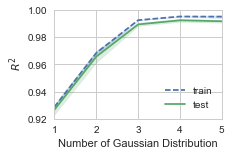

K_S


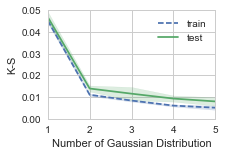

Chi_square


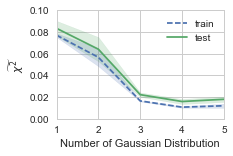

In [74]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.show()

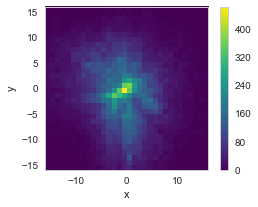

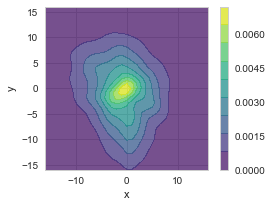

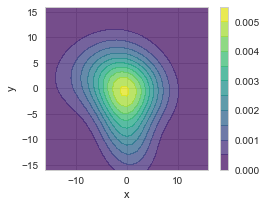

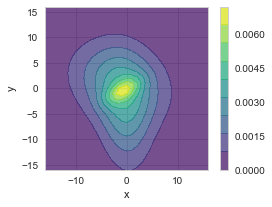

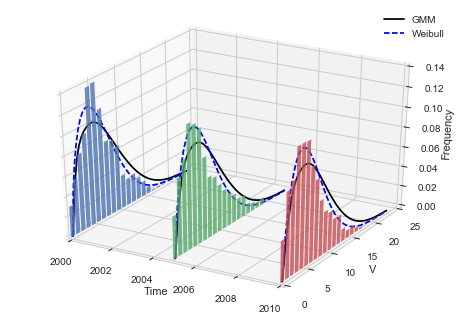

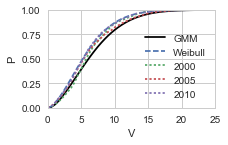

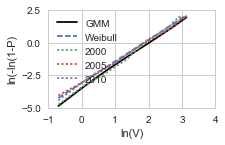

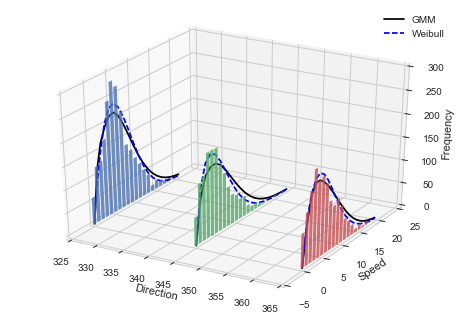

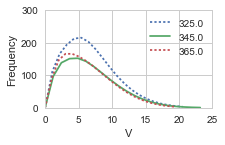

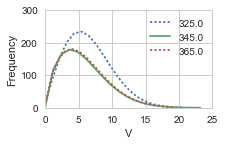

In [75]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [76]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
print(location_name)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)

springfield_IL
